# Assignment 4: Unsupervised Clustering Analysis
## Breast Cancer Wisconsin Dataset

This notebook conducts comprehensive clustering analysis using:
- Dimensionality Reduction: PCA and Autoencoders
- Clustering: K-Means and Gaussian Mixture Models
- Evaluation: Internal and External metrics

## 1. Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Import our custom implementations
from models import PCA_Scratch, Autoencoder_Scratch, KMeans_Scratch, GMM_Scratch
from metrics import (
    calculate_gap_statistic, silhouette_score_scratch, davies_bouldin_index,
    calinski_harabasz_scratch, purity_score, adjusted_rand_index_scratch,
    normalized_mutual_info_scratch, confusion_matrix_scratch, align_predictions
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Load the Breast Cancer Wisconsin dataset
data = load_breast_cancer()
X = data.data
y_true = data.target  # 0: malignant, 1: benign (only for evaluation)
feature_names = data.feature_names

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Class distribution: Malignant={np.sum(y_true==0)}, Benign={np.sum(y_true==1)}")

Dataset shape: (569, 30)
Number of features: 30
Number of samples: 569
Class distribution: Malignant=212, Benign=357


In [3]:
# Standardize the data (critical for PCA, Autoencoder, and distance-based clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data standardized successfully")
print(f"Mean: {np.mean(X_scaled, axis=0)[:5]}...")
print(f"Std: {np.std(X_scaled, axis=0)[:5]}...")

Data standardized successfully
Mean: [-3.16286735e-15 -6.53060890e-15 -7.07889127e-16 -8.79983452e-16
  6.13217737e-15]...
Std: [1. 1. 1. 1. 1.]...


## 2. Helper Functions for Evaluation and Visualization

In [4]:
def compute_all_metrics(X, labels, y_true, method_name):
    """Compute all internal and external validation metrics."""
    metrics = {}
    
    # Internal metrics
    metrics['Silhouette'] = silhouette_score_scratch(X, labels)
    metrics['Davies-Bouldin'] = davies_bouldin_index(X, labels)
    metrics['Calinski-Harabasz'] = calinski_harabasz_scratch(X, labels)
    
    # WCSS (inertia)
    unique_labels = np.unique(labels)
    centroids = np.array([X[labels == k].mean(axis=0) for k in unique_labels])
    wcss = 0
    for k in unique_labels:
        cluster_points = X[labels == k]
        wcss += np.sum((cluster_points - centroids[k]) ** 2)
    metrics['WCSS'] = wcss
    
    # External metrics
    metrics['ARI'] = adjusted_rand_index_scratch(y_true, labels)
    metrics['NMI'] = normalized_mutual_info_scratch(y_true, labels)
    metrics['Purity'] = purity_score(y_true, labels)
    
    return metrics

In [5]:
def plot_2d_projection(X_2d, labels, y_true, title, subplot_position=None):
    """Plot 2D projection with cluster assignments and true labels."""
    if subplot_position:
        plt.subplot(subplot_position)
    else:
        plt.figure(figsize=(14, 6))
    
    # Plot with predicted clusters
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', 
                         alpha=0.6, edgecolors='k', s=50)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'{title} - Predicted Clusters')
    plt.grid(True, alpha=0.3)
    
    # Plot with true labels
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_true, cmap='RdYlBu', 
                         alpha=0.6, edgecolors='k', s=50)
    plt.colorbar(scatter, label='True Class (0:Malignant, 1:Benign)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'{title} - True Labels')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()

In [6]:
def plot_elbow_curve(k_range, inertias, optimal_k=None):
    """Plot elbow curve for K-Means."""
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    if optimal_k:
        plt.axvline(x=optimal_k, color='r', linestyle='--', 
                   label=f'Optimal k={optimal_k}')
        plt.legend()
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Inertia (WCSS)', fontsize=12)
    plt.title('Elbow Method for Optimal k', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

In [7]:
def plot_silhouette_analysis(k_range, silhouette_scores, optimal_k=None):
    """Plot silhouette scores for different k values."""
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
    if optimal_k:
        plt.axvline(x=optimal_k, color='r', linestyle='--', 
                   label=f'Optimal k={optimal_k}')
        plt.legend()
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.title('Silhouette Analysis for Optimal k', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

In [8]:
def plot_gap_statistic(k_range, gaps, errors):
    """Plot gap statistic with error bars."""
    plt.figure(figsize=(10, 6))
    plt.errorbar(k_range, gaps, yerr=errors, fmt='ro-', linewidth=2, 
                markersize=8, capsize=5)
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Gap Statistic', fontsize=12)
    plt.title('Gap Statistic for Optimal k', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

In [9]:
def plot_bic_aic(n_components_range, bic_scores, aic_scores):
    """Plot BIC and AIC curves for GMM."""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(n_components_range, bic_scores, 'bo-', linewidth=2, markersize=8)
    optimal_bic = n_components_range[np.argmin(bic_scores)]
    plt.axvline(x=optimal_bic, color='r', linestyle='--', 
               label=f'Optimal components={optimal_bic}')
    plt.xlabel('Number of Components', fontsize=12)
    plt.ylabel('BIC', fontsize=12)
    plt.title('Bayesian Information Criterion', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(n_components_range, aic_scores, 'go-', linewidth=2, markersize=8)
    optimal_aic = n_components_range[np.argmin(aic_scores)]
    plt.axvline(x=optimal_aic, color='r', linestyle='--', 
               label=f'Optimal components={optimal_aic}')
    plt.xlabel('Number of Components', fontsize=12)
    plt.ylabel('AIC', fontsize=12)
    plt.title('Akaike Information Criterion', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()

In [10]:
def plot_confusion_matrix(y_true, y_pred, title):
    """Plot confusion matrix."""
    # Align predictions to true labels for better visualization
    y_pred_aligned = align_predictions(y_true, y_pred)
    
    cm = sklearn_confusion_matrix(y_true, y_pred_aligned)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['Malignant', 'Benign'],
               yticklabels=['Malignant', 'Benign'])
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title(title, fontsize=14)
    plt.tight_layout()

## 3. Experiment 1: K-Means on Original Data

In [11]:
print("=" * 80)
print("EXPERIMENT 1: K-Means on Original Data")
print("=" * 80)

# Test range of k values
k_range = range(2, 11)
inertias = []
silhouette_scores = []

print("\nTesting different k values...")
for k in k_range:
    kmeans = KMeans_Scratch(n_clusters=k, init='k-means++', max_iter=300)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score_scratch(X_scaled, kmeans.labels)
    silhouette_scores.append(sil_score)
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f}")

EXPERIMENT 1: K-Means on Original Data

Testing different k values...
k=2: Inertia=11595.53, Silhouette=0.3434
k=3: Inertia=10065.44, Silhouette=0.3151
k=4: Inertia=9335.81, Silhouette=0.1603
k=5: Inertia=8708.67, Silhouette=0.1456
k=6: Inertia=8196.86, Silhouette=0.1770
k=7: Inertia=7698.74, Silhouette=0.1368
k=8: Inertia=7304.94, Silhouette=0.1462
k=9: Inertia=6987.17, Silhouette=0.1255
k=10: Inertia=6850.45, Silhouette=0.1170



--- Finding Optimal k ---


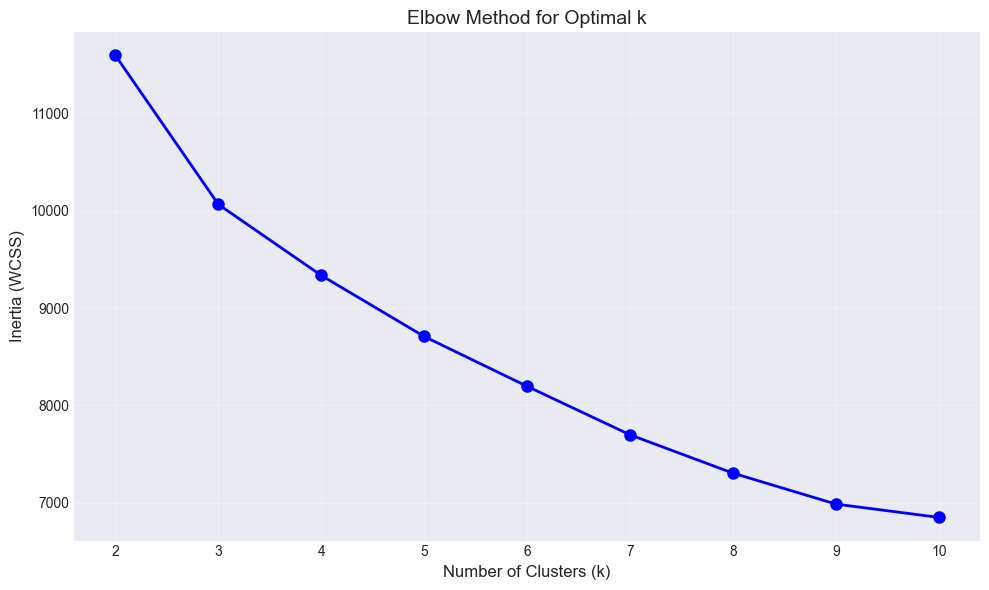

Optimal k (Silhouette): 2


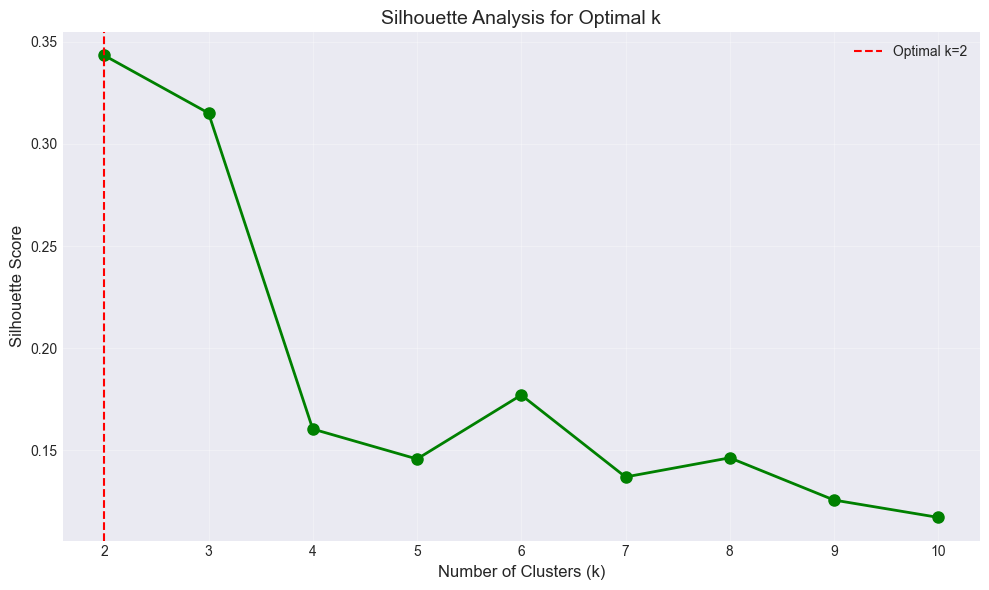


Computing Gap Statistic (this may take a moment)...


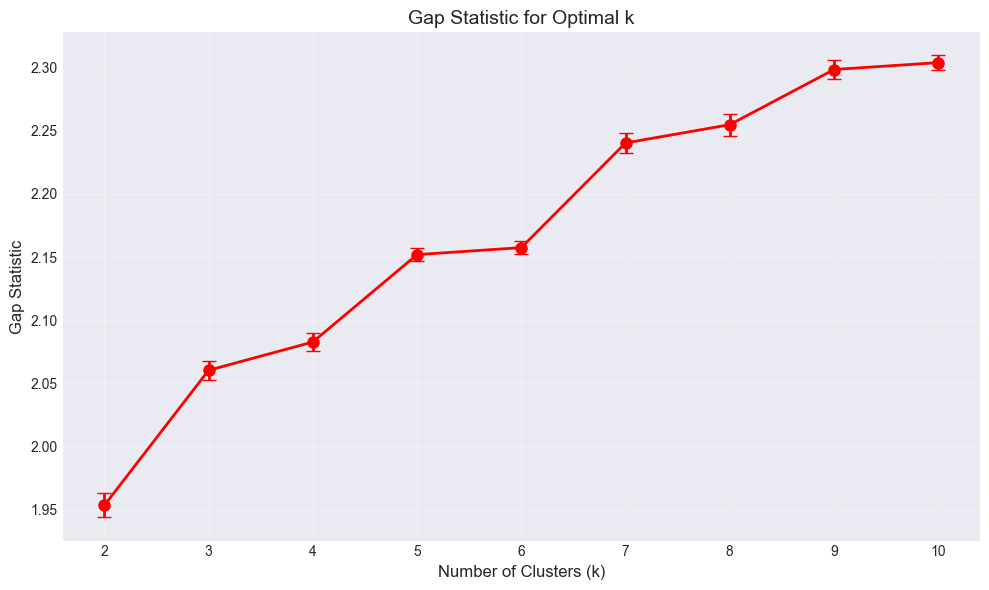

Optimal k (Gap Statistic): 9


In [12]:
# Find optimal k using different methods
print("\n--- Finding Optimal k ---")

# Method 1: Elbow method (look for the "elbow" in the plot)
plot_elbow_curve(k_range, inertias)
plt.show()

# Method 2: Silhouette analysis (maximize silhouette score)
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"Optimal k (Silhouette): {optimal_k_silhouette}")
plot_silhouette_analysis(k_range, silhouette_scores, optimal_k_silhouette)
plt.show()

# Method 3: Gap statistic
print("\nComputing Gap Statistic (this may take a moment)...")
gaps, errors = calculate_gap_statistic(X_scaled, k_range, KMeans_Scratch, n_references=5)
plot_gap_statistic(k_range, gaps, errors)
plt.show()

# Select optimal k based on gap statistic (k where gap(k) >= gap(k+1) - s(k+1))
optimal_k_gap = k_range[0]
for i in range(len(gaps) - 1):
    if gaps[i] >= gaps[i+1] - errors[i+1]:
        optimal_k_gap = k_range[i]
        break
print(f"Optimal k (Gap Statistic): {optimal_k_gap}")


--- Comparing Initialization Methods ---
K-Means++ converged in 8 iterations
Final inertia: 11595.53
Random init converged in 9 iterations
Final inertia: 11595.68


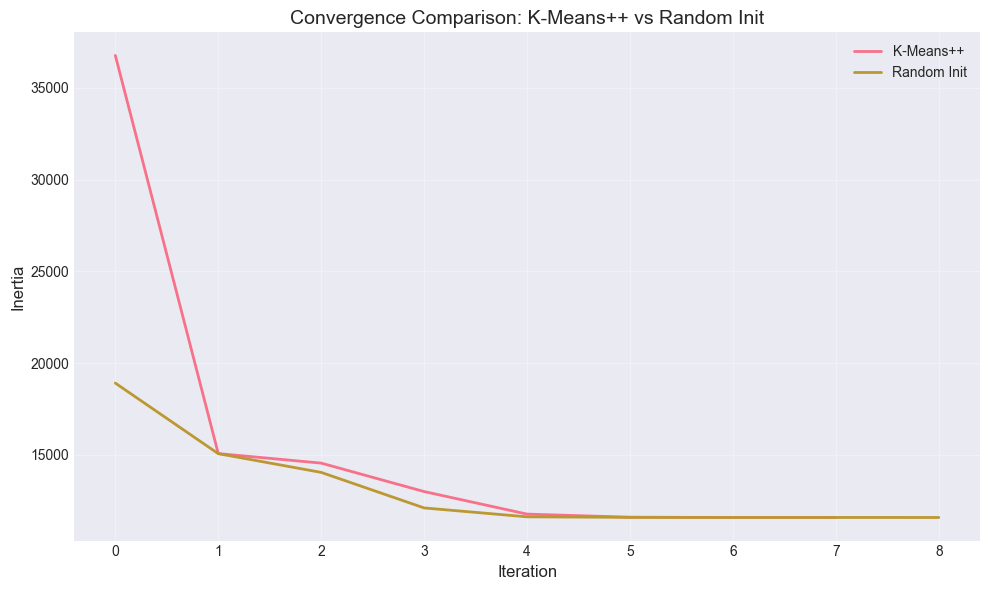

In [53]:
# Compare K-Means++ vs Random initialization
print("\n--- Comparing Initialization Methods ---")
optimal_k = 2  # Using 2 clusters (matching the dataset classes)

# K-Means++
kmeans_pp = KMeans_Scratch(n_clusters=optimal_k, init='k-means++', max_iter=300)
kmeans_pp.fit(X_scaled)
print(f"K-Means++ converged in {len(kmeans_pp.inertia_history)} iterations")
print(f"Final inertia: {kmeans_pp.inertia_:.2f}")

# Random initialization
kmeans_random = KMeans_Scratch(n_clusters=optimal_k, init='random', max_iter=300)
kmeans_random.fit(X_scaled)
print(f"Random init converged in {len(kmeans_random.inertia_history)} iterations")
print(f"Final inertia: {kmeans_random.inertia_:.2f}")

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(kmeans_pp.inertia_history, label='K-Means++', linewidth=2)
plt.plot(kmeans_random.inertia_history, label='Random Init', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Convergence Comparison: K-Means++ vs Random Init', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Evaluate best K-Means model
print("\n--- Experiment 1 Results (K-Means with K-Means++) ---")
exp1_metrics = compute_all_metrics(X_scaled, kmeans_pp.labels, y_true, 
                                   "K-Means Original")

for metric, value in exp1_metrics.items():
    print(f"{metric}: {value:.4f}")


--- Experiment 1 Results (K-Means with K-Means++) ---
Silhouette: 0.3450
Davies-Bouldin: 1.3123
Calinski-Harabasz: 267.6964
WCSS: 11595.4615
ARI: 0.6707
NMI: 0.5546
Purity: 0.9104


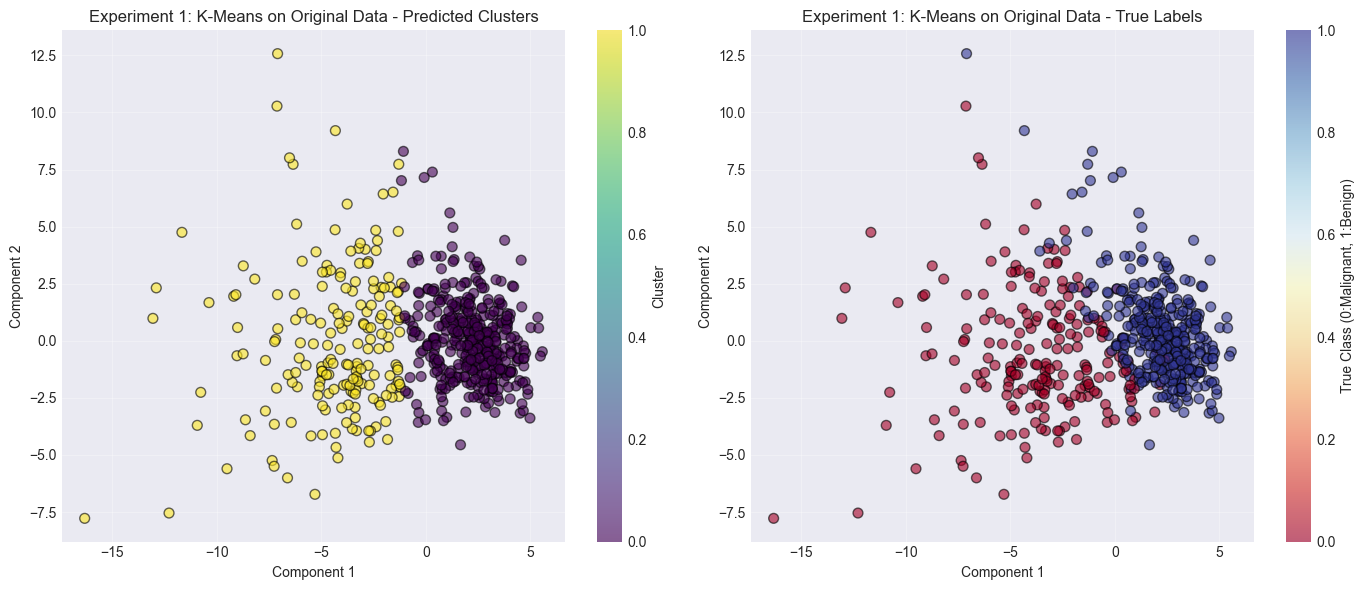

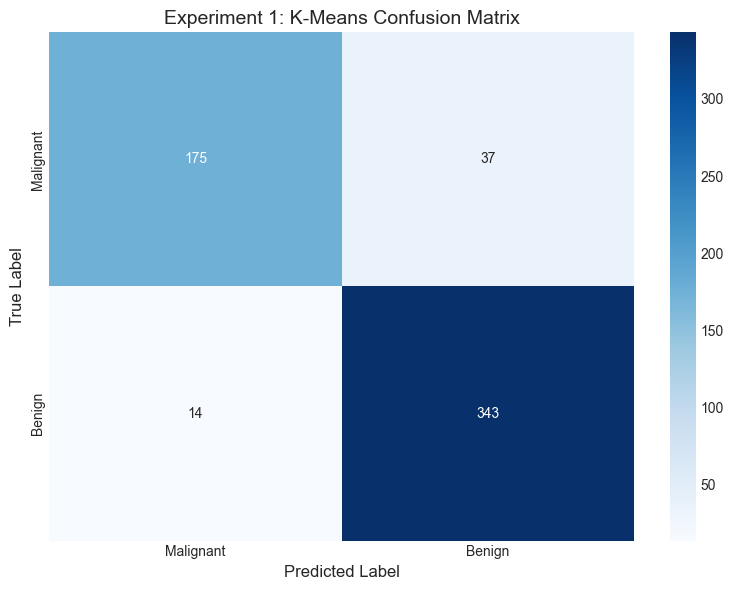

In [15]:
# Visualize with PCA for 2D projection
pca_viz = PCA_Scratch(n_components=2)
pca_viz.fit(X_scaled)
X_2d = pca_viz.transform(X_scaled)

plot_2d_projection(X_2d, kmeans_pp.labels, y_true, 
                  "Experiment 1: K-Means on Original Data")
plt.show()

plot_confusion_matrix(y_true, kmeans_pp.labels, 
                     "Experiment 1: K-Means Confusion Matrix")
plt.show()

## 4. Experiment 2: GMM on Original Data

In [16]:
print("=" * 80)
print("EXPERIMENT 2: GMM on Original Data")
print("=" * 80)

# Test different numbers of components
n_components_range = range(2, 11)
cov_types = ['full', 'tied', 'diag', 'spherical']

results_gmm = {cov_type: {'bic': [], 'aic': [], 'log_likelihood': []} 
               for cov_type in cov_types}

print("\nTesting different covariance types and number of components...")
for cov_type in cov_types:
    print(f"\n--- Covariance Type: {cov_type} ---")
    for n_comp in n_components_range:
        gmm = GMM_Scratch(n_components=n_comp, cov_type=cov_type, max_iter=100)
        gmm.fit(X_scaled)
        bic, aic = gmm.get_bic_aic(X_scaled)
        log_lik = gmm.log_likelihood_history[-1]
        
        results_gmm[cov_type]['bic'].append(bic)
        results_gmm[cov_type]['aic'].append(aic)
        results_gmm[cov_type]['log_likelihood'].append(log_lik)
        
        print(f"n={n_comp}: BIC={bic:.2f}, AIC={aic:.2f}, LogLik={log_lik:.2f}")

EXPERIMENT 2: GMM on Original Data

Testing different covariance types and number of components...

--- Covariance Type: full ---
n=2: BIC=6793.32, AIC=2488.53, LogLik=-253.27
n=3: BIC=5976.42, AIC=-482.93, LogLik=1728.46
n=4: BIC=8978.29, AIC=364.38, LogLik=1800.81
n=5: BIC=7279.90, AIC=-3488.58, LogLik=4223.29
n=6: BIC=9829.52, AIC=-3093.52, LogLik=4521.76
n=7: BIC=9764.38, AIC=-5313.23, LogLik=6127.61
n=8: BIC=13286.32, AIC=-3945.86, LogLik=5939.93
n=9: BIC=10741.29, AIC=-8645.45, LogLik=8785.72
n=10: BIC=12982.89, AIC=-8558.41, LogLik=9238.21

--- Covariance Type: tied ---
n=2: BIC=11175.21, AIC=8890.33, LogLik=-3919.17
n=3: BIC=11138.32, AIC=8718.78, LogLik=-3802.39
n=4: BIC=11105.77, AIC=8551.57, LogLik=-3687.79
n=5: BIC=11056.79, AIC=8367.93, LogLik=-3564.96
n=6: BIC=10778.39, AIC=7954.87, LogLik=-3327.43
n=7: BIC=10836.11, AIC=7877.92, LogLik=-3257.96
n=8: BIC=9887.99, AIC=6795.14, LogLik=-2685.57
n=9: BIC=10417.08, AIC=7189.58, LogLik=-2851.79
n=10: BIC=10617.26, AIC=7255.10, 

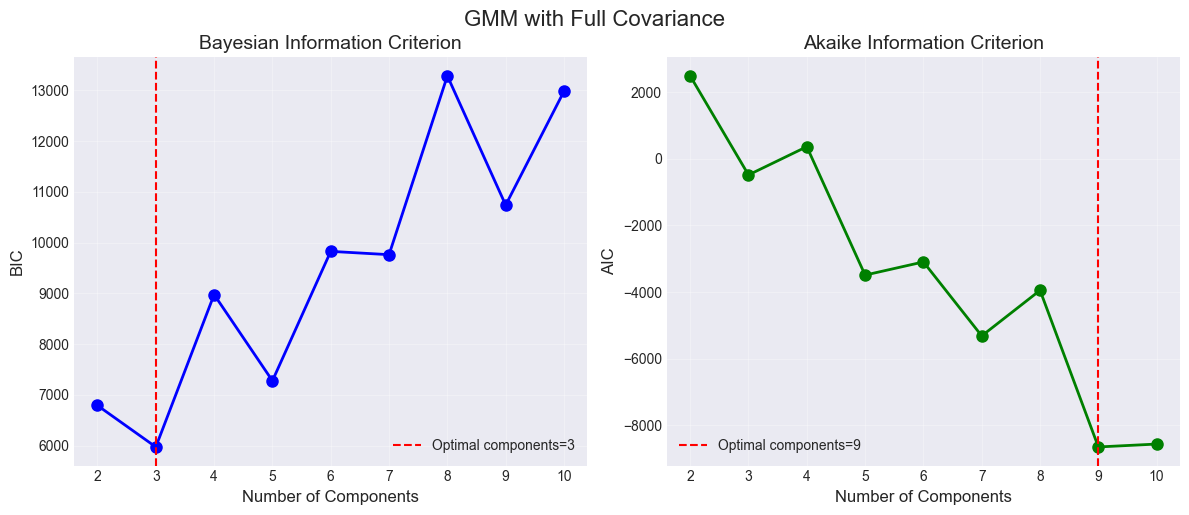

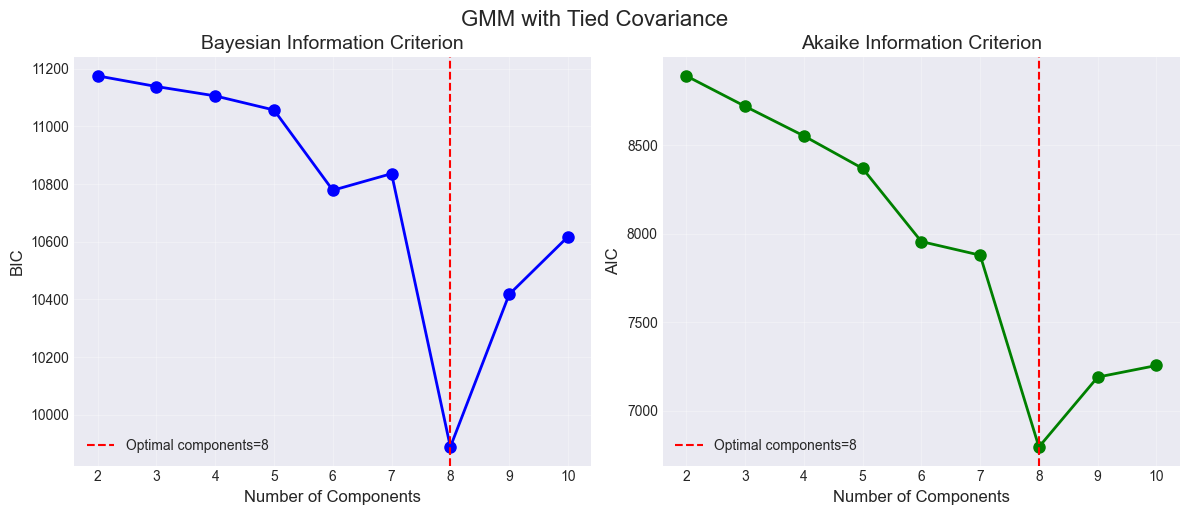

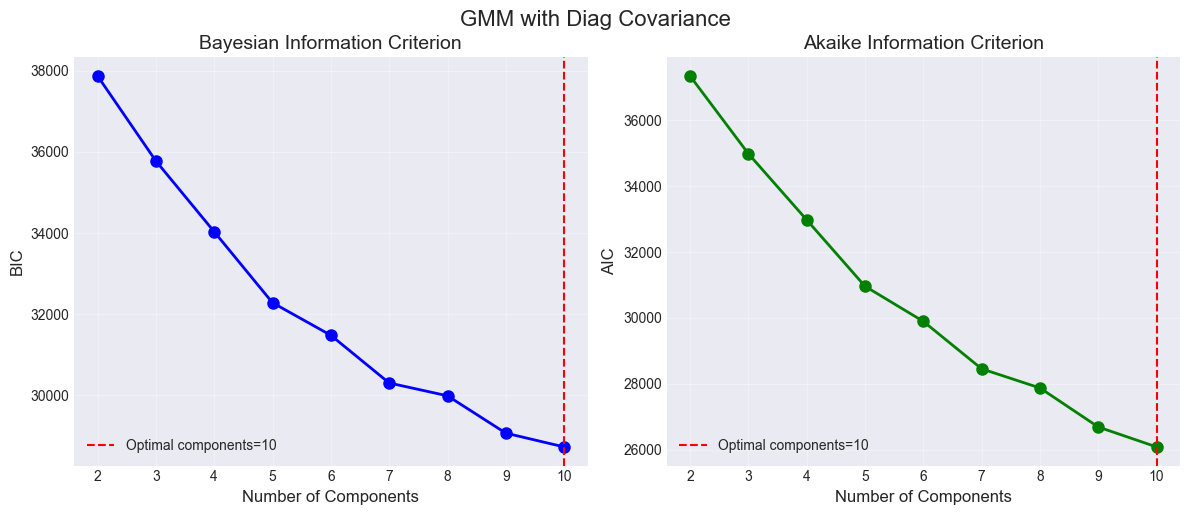

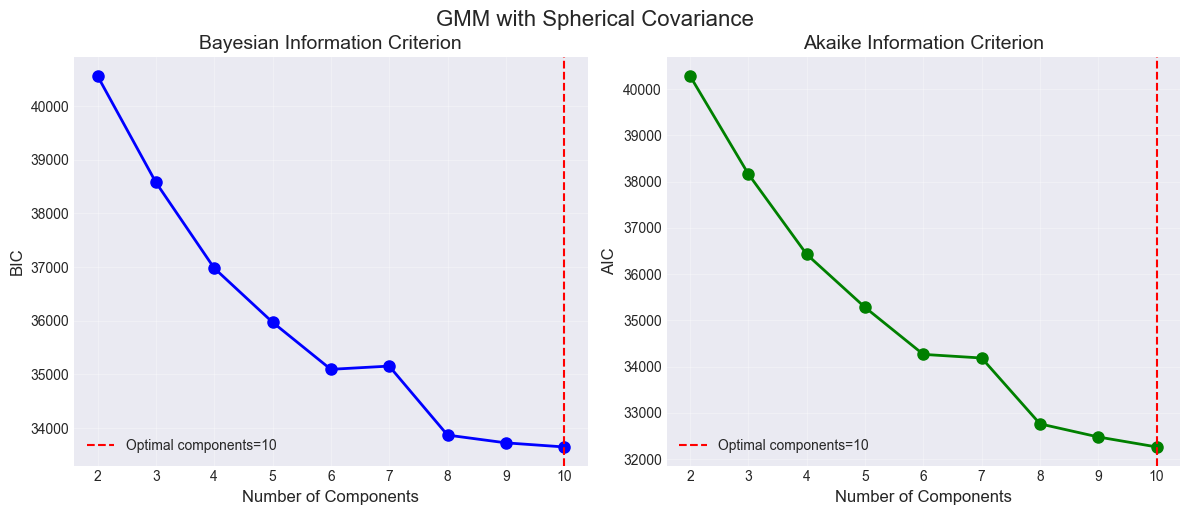

In [17]:
# Plot BIC/AIC for each covariance type
for cov_type in cov_types:
    plot_bic_aic(n_components_range, 
                results_gmm[cov_type]['bic'],
                results_gmm[cov_type]['aic'])
    plt.suptitle(f'GMM with {cov_type.capitalize()} Covariance', fontsize=16, y=1.02)
    plt.show()

In [18]:
# Find best model based on BIC
best_cov = None
best_n_comp = None
best_bic = np.inf

for cov_type in cov_types:
    min_bic_idx = np.argmin(results_gmm[cov_type]['bic'])
    min_bic = results_gmm[cov_type]['bic'][min_bic_idx]
    if min_bic < best_bic:
        best_bic = min_bic
        best_cov = cov_type
        best_n_comp = list(n_components_range)[min_bic_idx]

print(f"\n--- Best GMM Model ---")
print(f"Covariance Type: {best_cov}")
print(f"Number of Components: {best_n_comp}")
print(f"BIC: {best_bic:.2f}")


--- Best GMM Model ---
Covariance Type: full
Number of Components: 3
BIC: 5976.42


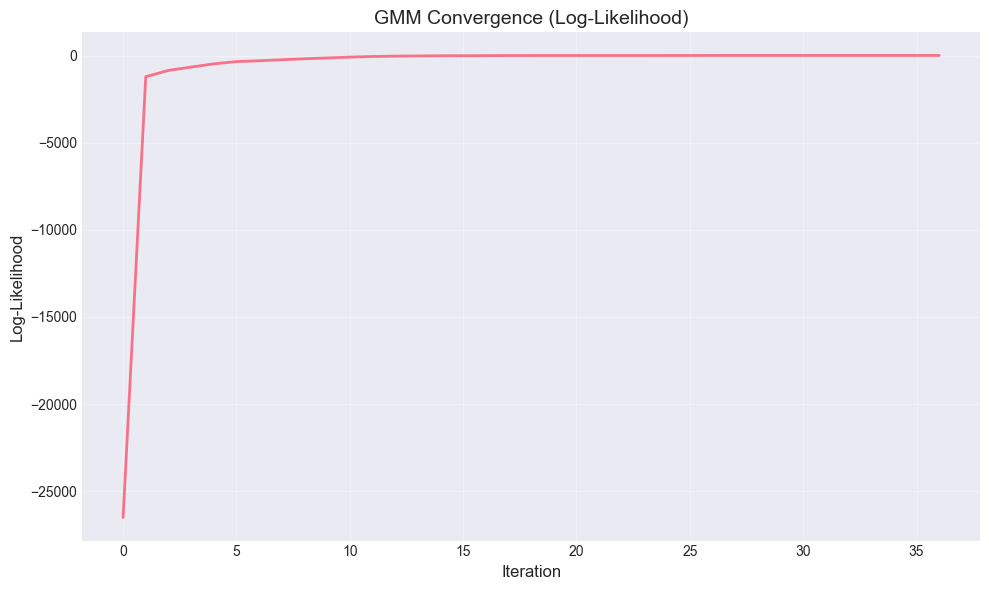

In [19]:
# Train best GMM model
gmm_best = GMM_Scratch(n_components=2, cov_type='full', max_iter=100)
gmm_best.fit(X_scaled)
gmm_labels = gmm_best.predict(X_scaled)

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(gmm_best.log_likelihood_history, linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Log-Likelihood', fontsize=12)
plt.title('GMM Convergence (Log-Likelihood)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
# Evaluate GMM
print("\n--- Experiment 2 Results (GMM on Original Data) ---")
exp2_metrics = compute_all_metrics(X_scaled, gmm_labels, y_true, "GMM Original")
bic, aic = gmm_best.get_bic_aic(X_scaled)
exp2_metrics['BIC'] = bic
exp2_metrics['AIC'] = aic
exp2_metrics['Log-Likelihood'] = gmm_best.log_likelihood_history[-1]

for metric, value in exp2_metrics.items():
    print(f"{metric}: {value:.4f}")


--- Experiment 2 Results (GMM on Original Data) ---
Silhouette: 0.3103
Davies-Bouldin: 1.3797
Calinski-Harabasz: 242.9312
WCSS: 11950.0150
ARI: 0.7927
NMI: 0.6825
Purity: 0.9455
BIC: 6263.1186
AIC: 1958.3331
Log-Likelihood: 11.8334


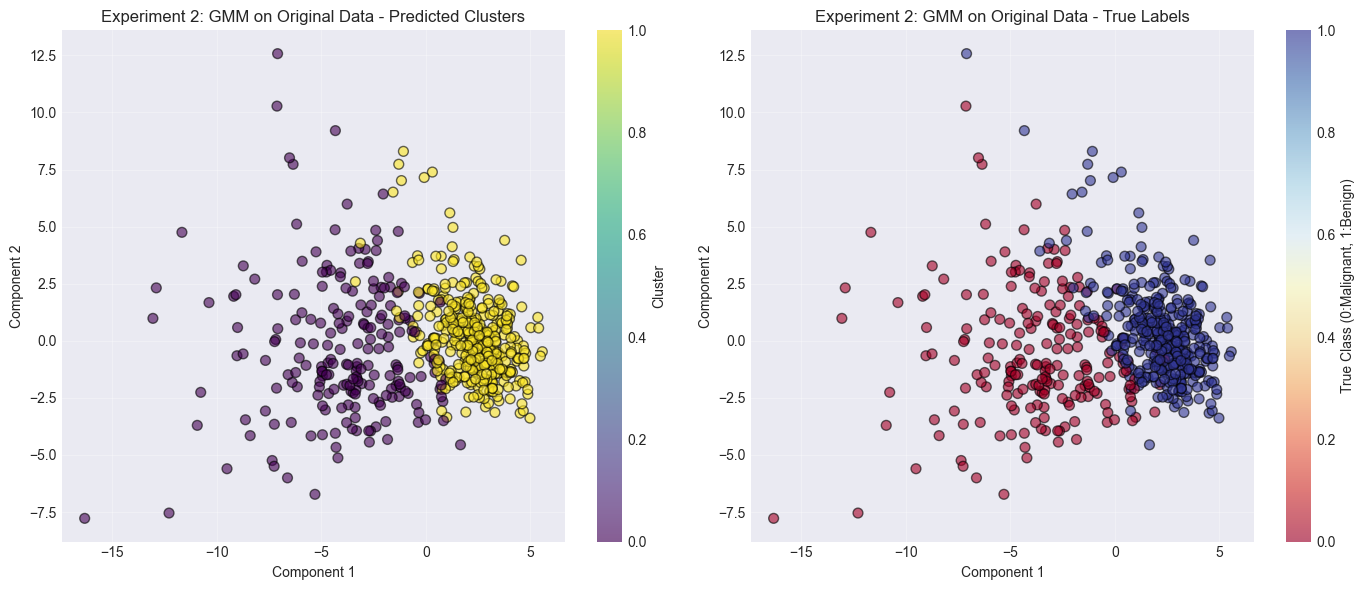

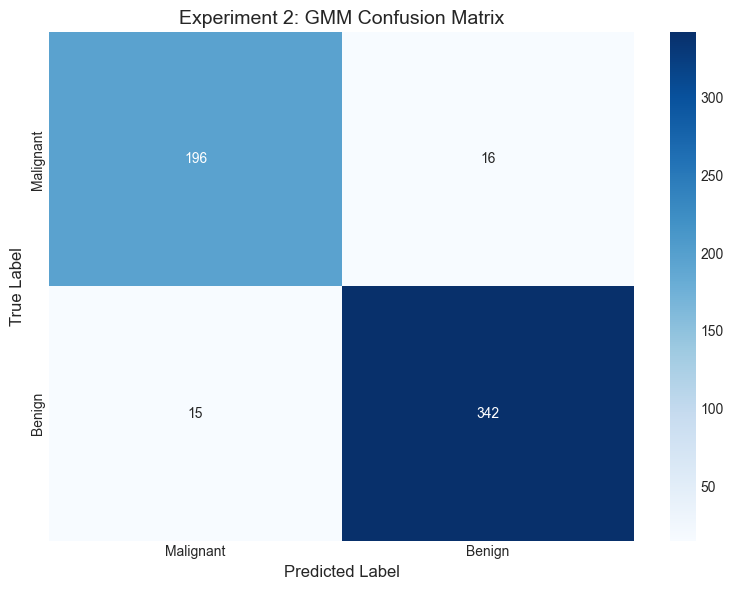

In [21]:
# Visualize
plot_2d_projection(X_2d, gmm_labels, y_true, 
                  "Experiment 2: GMM on Original Data")
plt.show()

plot_confusion_matrix(y_true, gmm_labels, 
                     "Experiment 2: GMM Confusion Matrix")
plt.show()

## 5. Experiment 3: K-Means after PCA

In [22]:
print("=" * 80)
print("EXPERIMENT 3: K-Means after PCA")
print("=" * 80)

# Test different numbers of principal components
n_components_list = [2, 5, 10, 15, 20]
exp3_results = []

for n_comp in n_components_list:
    print(f"\n--- PCA with {n_comp} components ---")
    
    # Apply PCA
    pca = PCA_Scratch(n_components=n_comp)
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)
    
    # Calculate reconstruction error
    recon_error = pca.get_reconstruction_error(X_scaled)
    explained_var = np.sum(pca.explained_variance_ratio)
    
    print(f"Explained Variance Ratio: {explained_var:.4f}")
    print(f"Reconstruction Error: {recon_error:.4f}")
    
    # Apply K-Means
    kmeans = KMeans_Scratch(n_clusters=2, init='k-means++', max_iter=300)
    kmeans.fit(X_pca)
    
    # Compute metrics
    metrics = compute_all_metrics(X_pca, kmeans.labels, y_true, 
                                 f"K-Means PCA-{n_comp}")
    metrics['n_components'] = n_comp
    metrics['explained_variance'] = explained_var
    metrics['reconstruction_error'] = recon_error
    
    exp3_results.append(metrics)
    
    print(f"Silhouette Score: {metrics['Silhouette']:.4f}")
    print(f"ARI: {metrics['ARI']:.4f}")
    print(f"NMI: {metrics['NMI']:.4f}")

EXPERIMENT 3: K-Means after PCA

--- PCA with 2 components ---
Explained Variance Ratio: 1.0000
Reconstruction Error: 0.3676
Silhouette Score: 0.5081
ARI: 0.6650
NMI: 0.5474

--- PCA with 5 components ---
Explained Variance Ratio: 1.0000
Reconstruction Error: 0.1527
Silhouette Score: 0.3919
ARI: 0.6536
NMI: 0.5324

--- PCA with 10 components ---
Explained Variance Ratio: 1.0000
Reconstruction Error: 0.0484
Silhouette Score: 0.3577
ARI: 0.6765
NMI: 0.5620

--- PCA with 15 components ---
Explained Variance Ratio: 1.0000
Reconstruction Error: 0.0135
Silhouette Score: 0.3481
ARI: 0.6765
NMI: 0.5620

--- PCA with 20 components ---
Explained Variance Ratio: 1.0000
Reconstruction Error: 0.0044
Silhouette Score: 0.3438
ARI: 0.6594
NMI: 0.5380


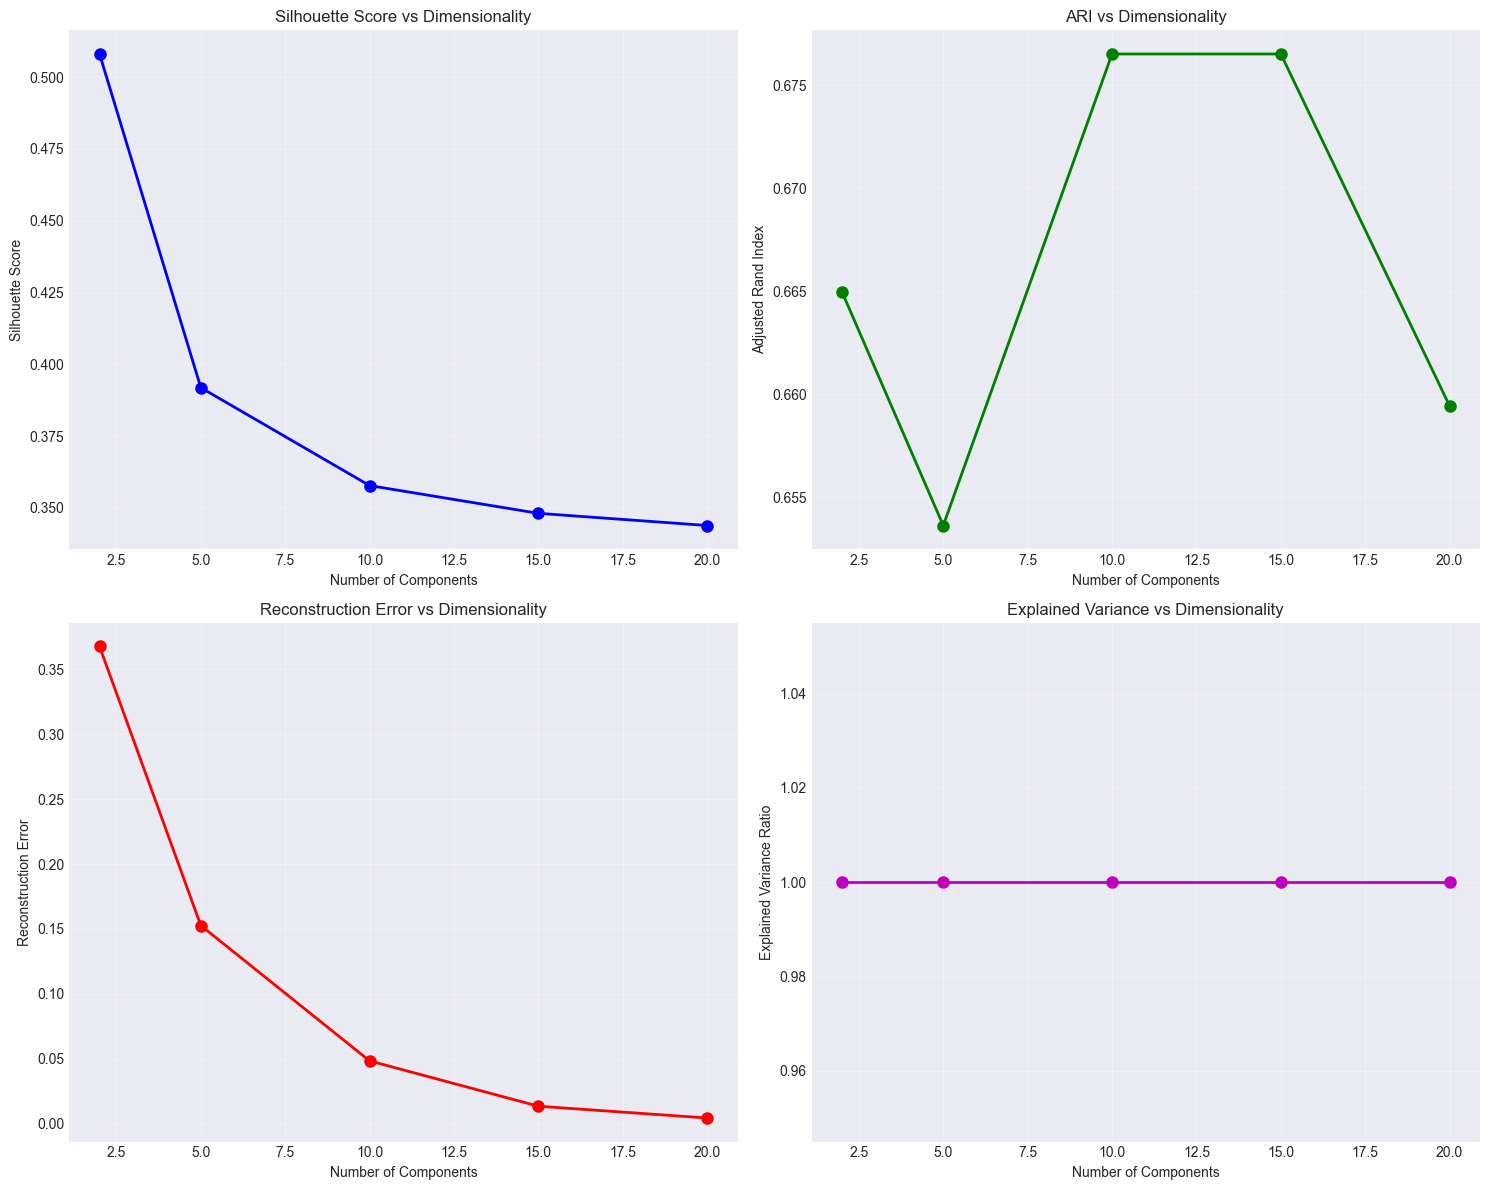

In [23]:
# Analyze trade-off between dimensionality and clustering quality
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Silhouette vs n_components
axes[0, 0].plot(n_components_list, 
               [r['Silhouette'] for r in exp3_results], 
               'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Components')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score vs Dimensionality')
axes[0, 0].grid(True, alpha=0.3)

# ARI vs n_components
axes[0, 1].plot(n_components_list, 
               [r['ARI'] for r in exp3_results], 
               'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Adjusted Rand Index')
axes[0, 1].set_title('ARI vs Dimensionality')
axes[0, 1].grid(True, alpha=0.3)

# Reconstruction Error vs n_components
axes[1, 0].plot(n_components_list, 
               [r['reconstruction_error'] for r in exp3_results], 
               'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Components')
axes[1, 0].set_ylabel('Reconstruction Error')
axes[1, 0].set_title('Reconstruction Error vs Dimensionality')
axes[1, 0].grid(True, alpha=0.3)

# Explained Variance vs n_components
axes[1, 1].plot(n_components_list, 
               [r['explained_variance'] for r in exp3_results], 
               'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Components')
axes[1, 1].set_ylabel('Explained Variance Ratio')
axes[1, 1].set_title('Explained Variance vs Dimensionality')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

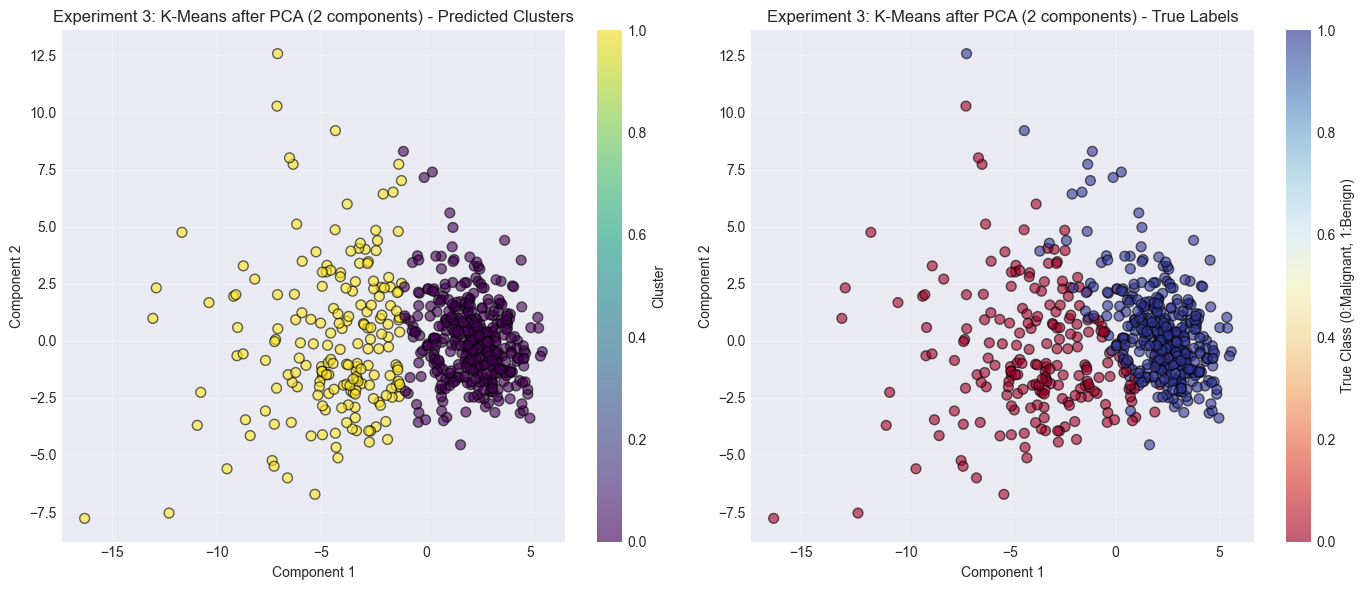

In [24]:
# Visualize best result (using 2 components for easy visualization)
pca_2 = PCA_Scratch(n_components=2)
pca_2.fit(X_scaled)
X_pca_2 = pca_2.transform(X_scaled)

kmeans_pca = KMeans_Scratch(n_clusters=2, init='k-means++', max_iter=300)
kmeans_pca.fit(X_pca_2)

plot_2d_projection(X_pca_2, kmeans_pca.labels, y_true, 
                  "Experiment 3: K-Means after PCA (2 components)")
plt.show()

## 6. Experiment 4: GMM after PCA

In [25]:
print("=" * 80)
print("EXPERIMENT 4: GMM after PCA")
print("=" * 80)

exp4_results = []

for n_comp in n_components_list:
    print(f"\n--- PCA with {n_comp} components ---")
    
    # Apply PCA
    pca = PCA_Scratch(n_components=n_comp)
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)
    
    recon_error = pca.get_reconstruction_error(X_scaled)
    explained_var = np.sum(pca.explained_variance_ratio)
    
    # Test different covariance types
    best_cov_for_dim = None
    best_bic_for_dim = np.inf
    best_gmm = None
    
    for cov_type in cov_types:
        gmm = GMM_Scratch(n_components=2, cov_type=cov_type, max_iter=100)
        gmm.fit(X_pca)
        bic, aic = gmm.get_bic_aic(X_pca)
        
        if bic < best_bic_for_dim:
            best_bic_for_dim = bic
            best_cov_for_dim = cov_type
            best_gmm = gmm
    
    # Get labels from best model
    gmm_labels = best_gmm.predict(X_pca)
    
    # Compute metrics
    metrics = compute_all_metrics(X_pca, gmm_labels, y_true, 
                                 f"GMM PCA-{n_comp}")
    bic, aic = best_gmm.get_bic_aic(X_pca)
    
    metrics['n_components'] = n_comp
    metrics['best_cov_type'] = best_cov_for_dim
    metrics['BIC'] = bic
    metrics['AIC'] = aic
    metrics['explained_variance'] = explained_var
    metrics['reconstruction_error'] = recon_error
    
    exp4_results.append(metrics)
    
    print(f"Best Covariance Type: {best_cov_for_dim}")
    print(f"BIC: {bic:.2f}")
    print(f"Silhouette Score: {metrics['Silhouette']:.4f}")
    print(f"ARI: {metrics['ARI']:.4f}")

EXPERIMENT 4: GMM after PCA

--- PCA with 2 components ---
Best Covariance Type: spherical
BIC: 5407.88
Silhouette Score: 0.4682
ARI: 0.6156

--- PCA with 5 components ---
Best Covariance Type: full
BIC: 11261.32
Silhouette Score: 0.2759
ARI: 0.4427

--- PCA with 10 components ---
Best Covariance Type: diag
BIC: 17354.46
Silhouette Score: 0.2827
ARI: 0.0485

--- PCA with 15 components ---
Best Covariance Type: diag
BIC: 20261.63
Silhouette Score: 0.2628
ARI: 0.0771

--- PCA with 20 components ---
Best Covariance Type: diag
BIC: 19287.52
Silhouette Score: 0.2511
ARI: 0.1377


In [26]:
# Analyze how dimensionality affects optimal covariance type
print("\n--- Optimal Covariance Type by Dimensionality ---")
for result in exp4_results:
    print(f"n_components={result['n_components']}: {result['best_cov_type']}")


--- Optimal Covariance Type by Dimensionality ---
n_components=2: spherical
n_components=5: full
n_components=10: diag
n_components=15: diag
n_components=20: diag


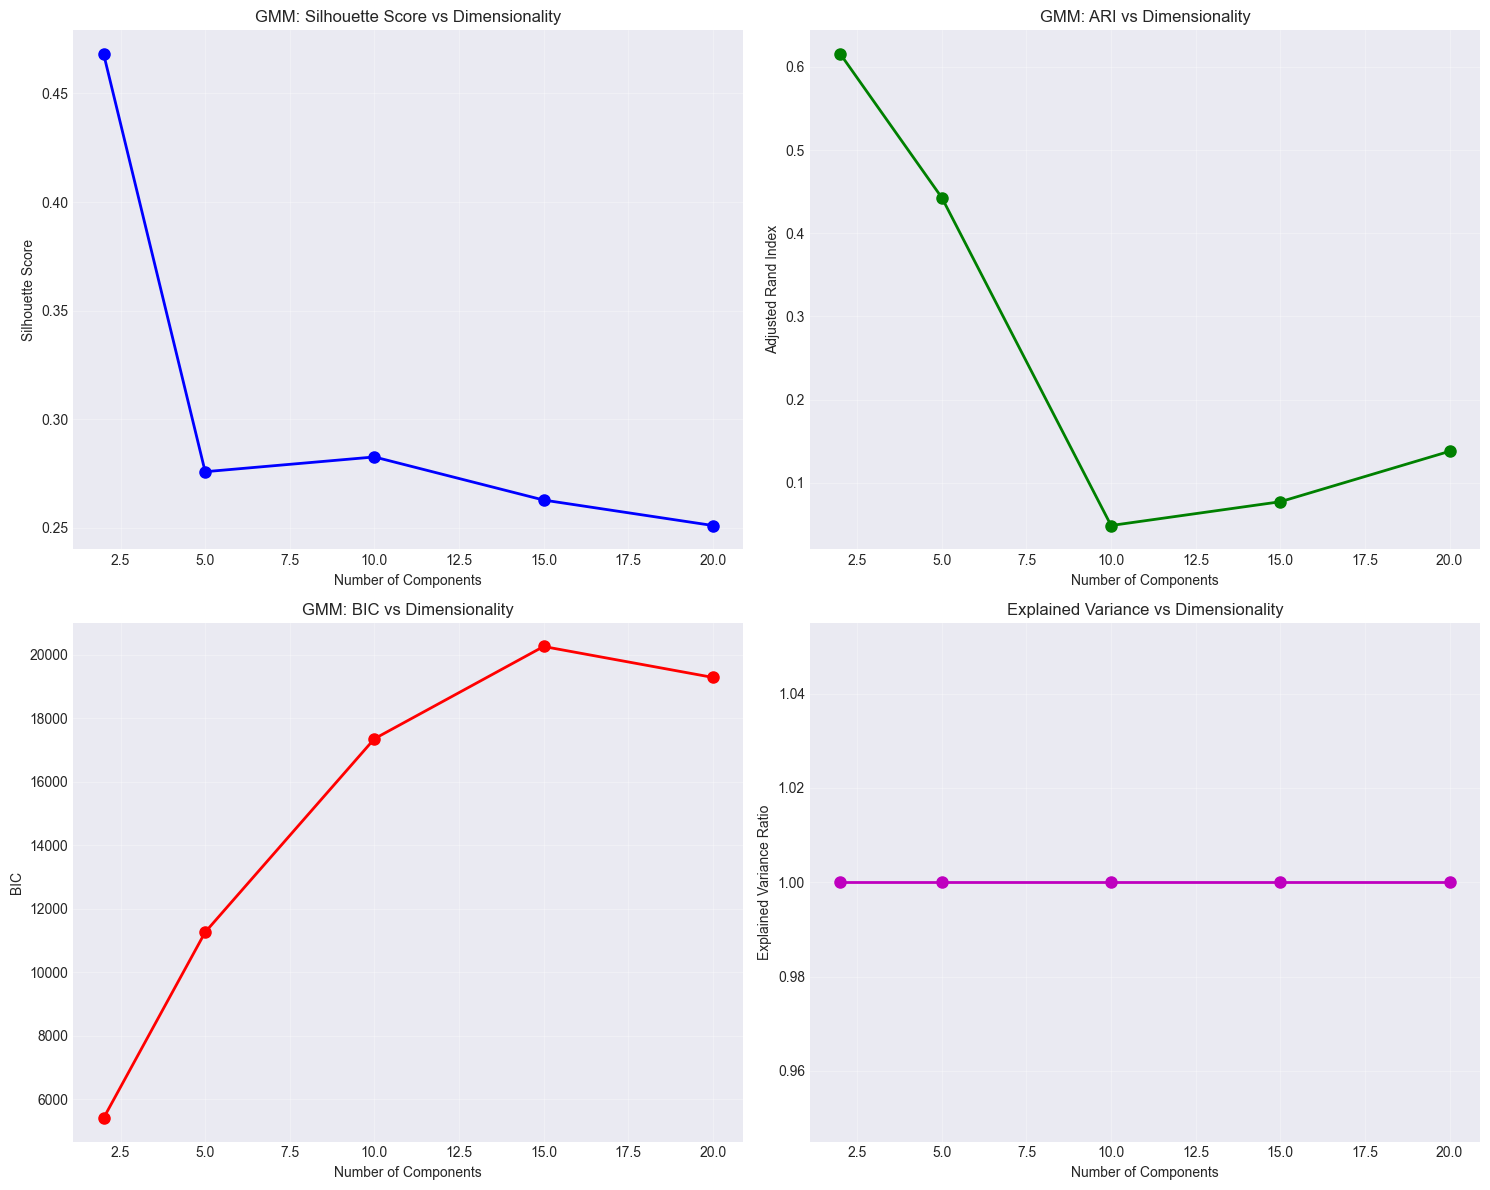

In [27]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].plot(n_components_list, 
               [r['Silhouette'] for r in exp4_results], 
               'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Components')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('GMM: Silhouette Score vs Dimensionality')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(n_components_list, 
               [r['ARI'] for r in exp4_results], 
               'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Adjusted Rand Index')
axes[0, 1].set_title('GMM: ARI vs Dimensionality')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(n_components_list, 
               [r['BIC'] for r in exp4_results], 
               'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Components')
axes[1, 0].set_ylabel('BIC')
axes[1, 0].set_title('GMM: BIC vs Dimensionality')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(n_components_list, 
               [r['explained_variance'] for r in exp4_results], 
               'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Components')
axes[1, 1].set_ylabel('Explained Variance Ratio')
axes[1, 1].set_title('Explained Variance vs Dimensionality')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

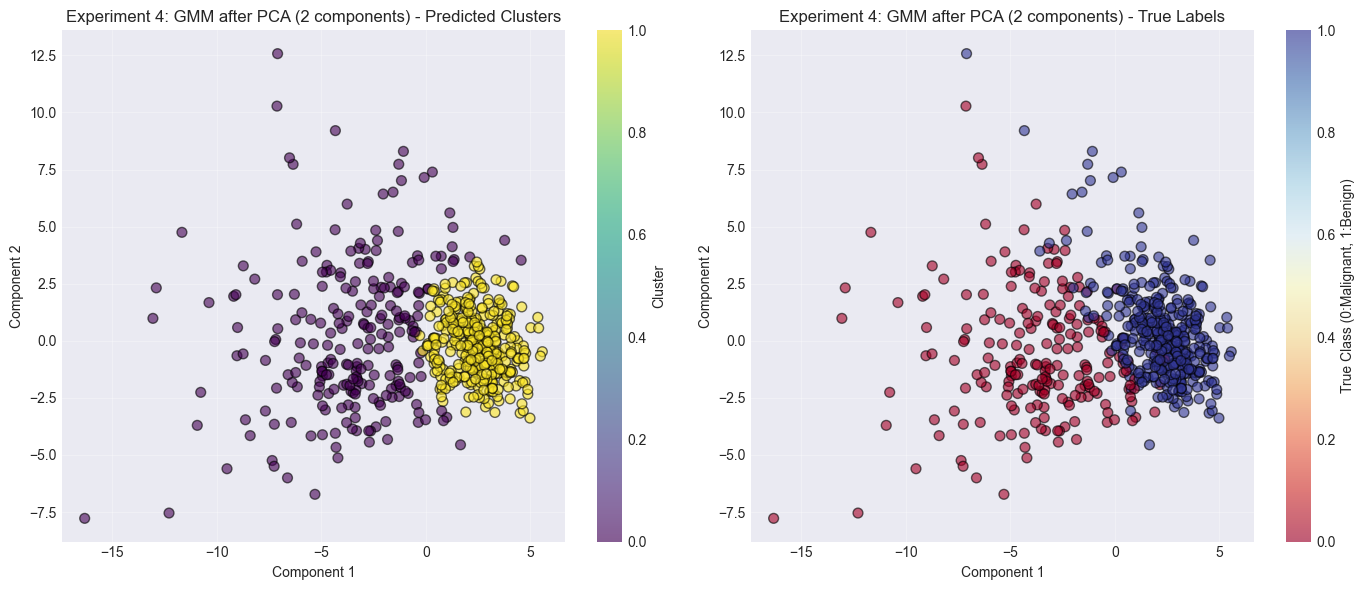

In [28]:
# Visualize best result
gmm_pca = GMM_Scratch(n_components=2, cov_type='full', max_iter=100)
gmm_pca.fit(X_pca_2)
gmm_pca_labels = gmm_pca.predict(X_pca_2)

plot_2d_projection(X_pca_2, gmm_pca_labels, y_true, 
                  "Experiment 4: GMM after PCA (2 components)")
plt.show()

## 7. Experiment 5: K-Means after Autoencoder

EXPERIMENT 5: K-Means after Autoencoder

--- Autoencoder with bottleneck dimension 2 ---
Training autoencoder...
Final Training Loss: 0.614885
Reconstruction Error: 0.607781
Silhouette Score: 0.7613
ARI: 0.4611
NMI: 0.4236


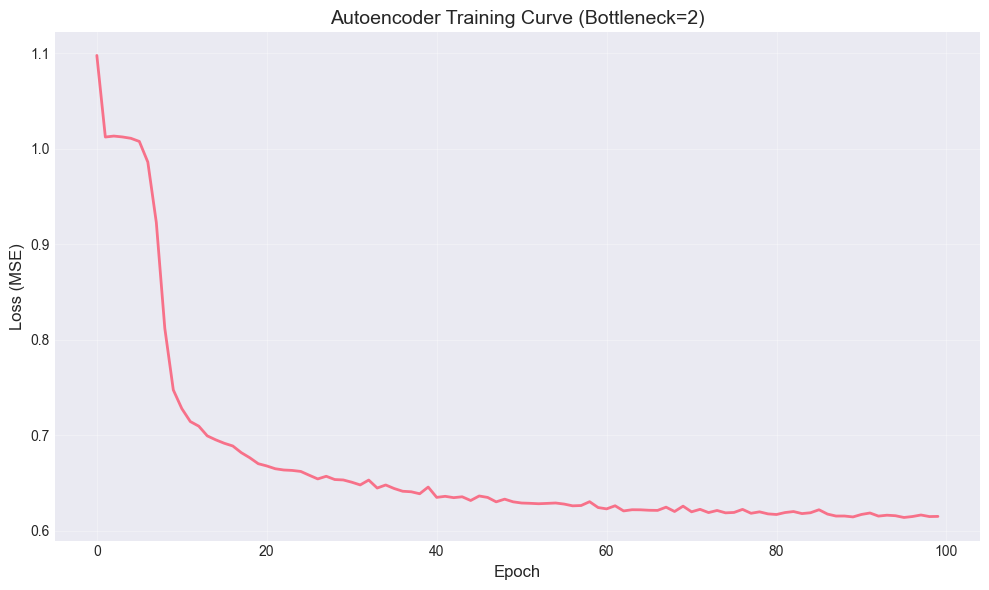


--- Autoencoder with bottleneck dimension 5 ---
Training autoencoder...
Final Training Loss: 0.325339
Reconstruction Error: 0.321258
Silhouette Score: 0.5889
ARI: 0.4746
NMI: 0.3767

--- Autoencoder with bottleneck dimension 10 ---
Training autoencoder...
Final Training Loss: 0.260237
Reconstruction Error: 0.256037
Silhouette Score: 0.5462
ARI: 0.4835
NMI: 0.4010

--- Autoencoder with bottleneck dimension 15 ---
Training autoencoder...
Final Training Loss: 0.236167
Reconstruction Error: 0.232679
Silhouette Score: 0.5047
ARI: 0.4336
NMI: 0.3577

--- Autoencoder with bottleneck dimension 20 ---
Training autoencoder...
Final Training Loss: 0.207743
Reconstruction Error: 0.203693
Silhouette Score: 0.5640
ARI: 0.1604
NMI: 0.1269


In [29]:
print("=" * 80)
print("EXPERIMENT 5: K-Means after Autoencoder")
print("=" * 80)

bottleneck_dims = [2, 5, 10, 15, 20]
exp5_results = []

for bottleneck_dim in bottleneck_dims:
    print(f"\n--- Autoencoder with bottleneck dimension {bottleneck_dim} ---")
    
    # Train Autoencoder
    autoencoder = Autoencoder_Scratch(
        input_dim=X_scaled.shape[1],
        bottleneck_dim=bottleneck_dim,
        hidden_layers=[64, 32],
        activation='relu'
    )
    
    print("Training autoencoder...")
    loss_history = autoencoder.fit(
        X_scaled,
        epochs=100,
        batch_size=32,
        learning_rate=0.001,
        l2_reg=0.0001
    )
    
    # Get encoded representation
    X_encoded = autoencoder.get_bottleneck(X_scaled)
    
    # Calculate reconstruction error
    X_reconstructed = autoencoder.forward(X_scaled)
    recon_error = np.mean((X_scaled - X_reconstructed) ** 2)
    
    print(f"Final Training Loss: {loss_history[-1]:.6f}")
    print(f"Reconstruction Error: {recon_error:.6f}")
    
    # Apply K-Means
    kmeans = KMeans_Scratch(n_clusters=2, init='k-means++', max_iter=300)
    kmeans.fit(X_encoded)
    
    # Compute metrics
    metrics = compute_all_metrics(X_encoded, kmeans.labels, y_true, 
                                 f"K-Means AE-{bottleneck_dim}")
    metrics['bottleneck_dim'] = bottleneck_dim
    metrics['reconstruction_error'] = recon_error
    metrics['final_training_loss'] = loss_history[-1]
    
    exp5_results.append(metrics)
    
    print(f"Silhouette Score: {metrics['Silhouette']:.4f}")
    print(f"ARI: {metrics['ARI']:.4f}")
    print(f"NMI: {metrics['NMI']:.4f}")
    
    # Plot training curve for first autoencoder
    if bottleneck_dim == bottleneck_dims[0]:
        plt.figure(figsize=(10, 6))
        plt.plot(loss_history, linewidth=2)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss (MSE)', fontsize=12)
        plt.title(f'Autoencoder Training Curve (Bottleneck={bottleneck_dim})', 
                 fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [30]:
# Compare with PCA results from Experiment 3
print("\n--- Comparing Autoencoder vs PCA ---")
comparison_df = pd.DataFrame({
    'Dimensions': n_components_list,
    'PCA_Silhouette': [r['Silhouette'] for r in exp3_results],
    'AE_Silhouette': [r['Silhouette'] for r in exp5_results],
    'PCA_ARI': [r['ARI'] for r in exp3_results],
    'AE_ARI': [r['ARI'] for r in exp5_results],
    'PCA_ReconError': [r['reconstruction_error'] for r in exp3_results],
    'AE_ReconError': [r['reconstruction_error'] for r in exp5_results]
})

print(comparison_df.to_string(index=False))


--- Comparing Autoencoder vs PCA ---
 Dimensions  PCA_Silhouette  AE_Silhouette  PCA_ARI   AE_ARI  PCA_ReconError  AE_ReconError
          2        0.508091       0.761305 0.664963 0.461127        0.367568       0.607781
          5        0.391857       0.588873 0.653625 0.474578        0.152657       0.321258
         10        0.357745       0.546187 0.676505 0.483457        0.048431       0.256037
         15        0.348078       0.504681 0.676505 0.433611        0.013512       0.232679
         20        0.343837       0.563981 0.659427 0.160399        0.004428       0.203693


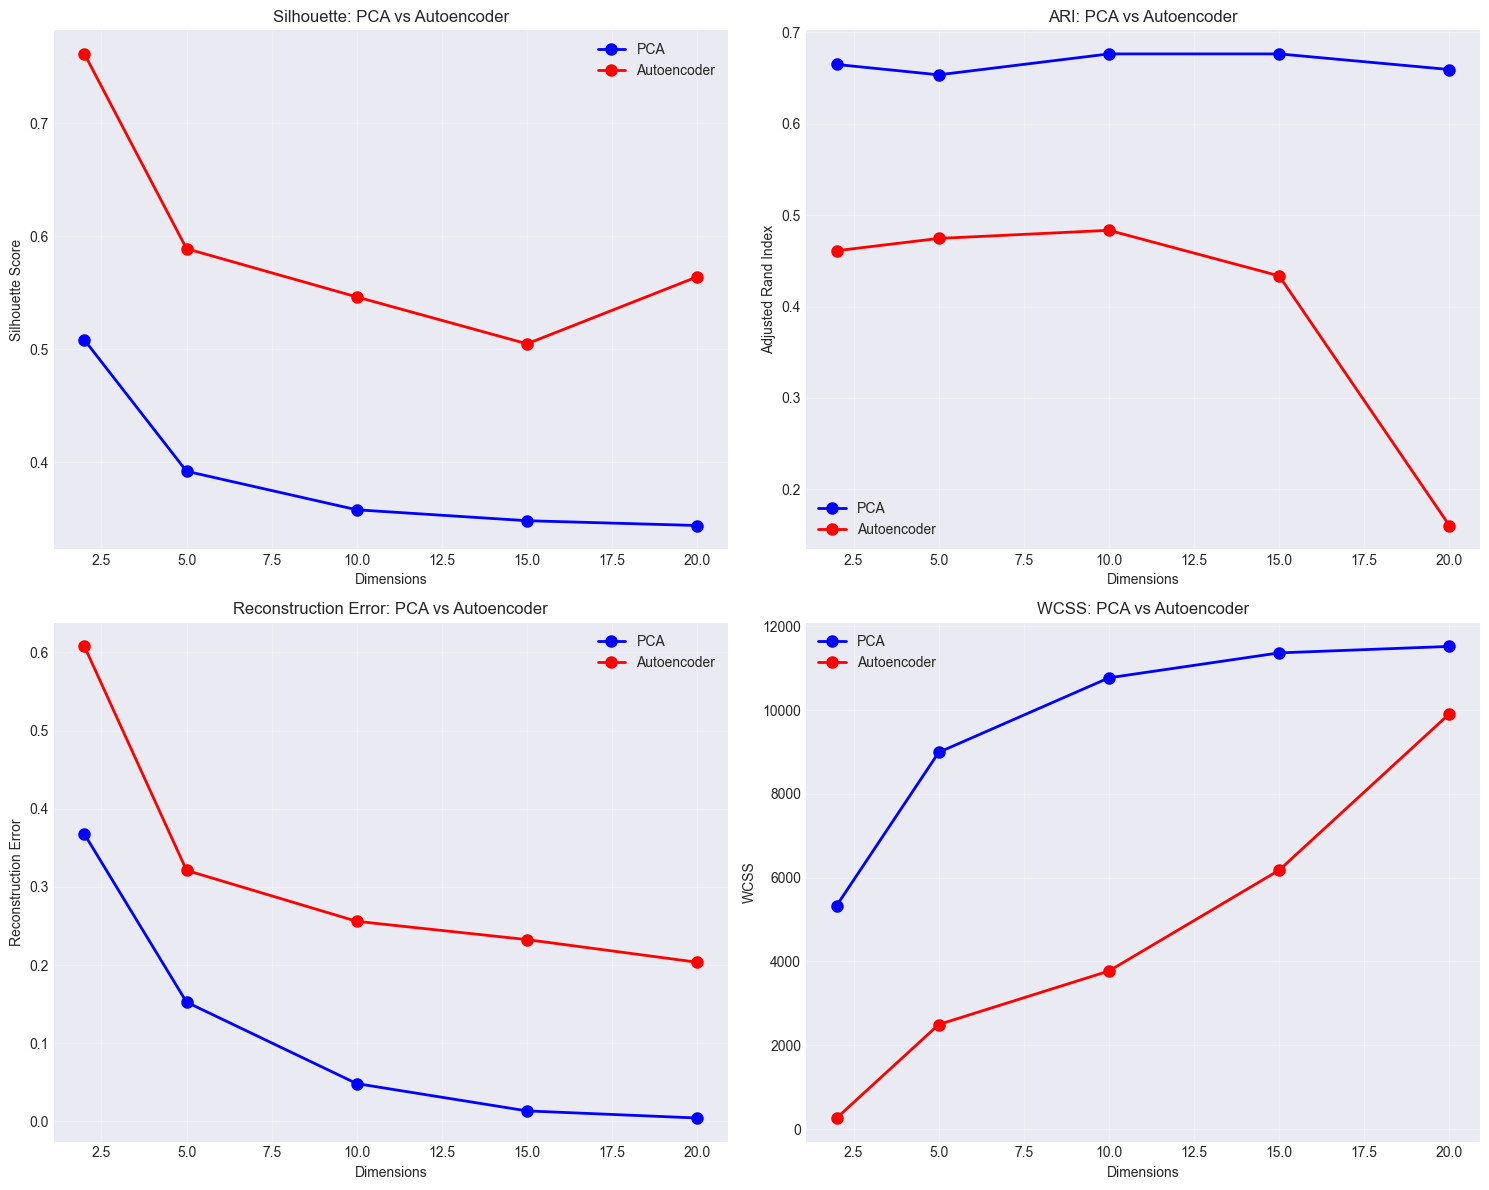

In [31]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Silhouette comparison
axes[0, 0].plot(bottleneck_dims, 
               [r['Silhouette'] for r in exp3_results], 
               'bo-', linewidth=2, markersize=8, label='PCA')
axes[0, 0].plot(bottleneck_dims, 
               [r['Silhouette'] for r in exp5_results], 
               'ro-', linewidth=2, markersize=8, label='Autoencoder')
axes[0, 0].set_xlabel('Dimensions')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette: PCA vs Autoencoder')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# ARI comparison
axes[0, 1].plot(bottleneck_dims, 
               [r['ARI'] for r in exp3_results], 
               'bo-', linewidth=2, markersize=8, label='PCA')
axes[0, 1].plot(bottleneck_dims, 
               [r['ARI'] for r in exp5_results], 
               'ro-', linewidth=2, markersize=8, label='Autoencoder')
axes[0, 1].set_xlabel('Dimensions')
axes[0, 1].set_ylabel('Adjusted Rand Index')
axes[0, 1].set_title('ARI: PCA vs Autoencoder')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Reconstruction Error comparison
axes[1, 0].plot(bottleneck_dims, 
               [r['reconstruction_error'] for r in exp3_results], 
               'bo-', linewidth=2, markersize=8, label='PCA')
axes[1, 0].plot(bottleneck_dims, 
               [r['reconstruction_error'] for r in exp5_results], 
               'ro-', linewidth=2, markersize=8, label='Autoencoder')
axes[1, 0].set_xlabel('Dimensions')
axes[1, 0].set_ylabel('Reconstruction Error')
axes[1, 0].set_title('Reconstruction Error: PCA vs Autoencoder')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# WCSS comparison
axes[1, 1].plot(bottleneck_dims, 
               [r['WCSS'] for r in exp3_results], 
               'bo-', linewidth=2, markersize=8, label='PCA')
axes[1, 1].plot(bottleneck_dims, 
               [r['WCSS'] for r in exp5_results], 
               'ro-', linewidth=2, markersize=8, label='Autoencoder')
axes[1, 1].set_xlabel('Dimensions')
axes[1, 1].set_ylabel('WCSS')
axes[1, 1].set_title('WCSS: PCA vs Autoencoder')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

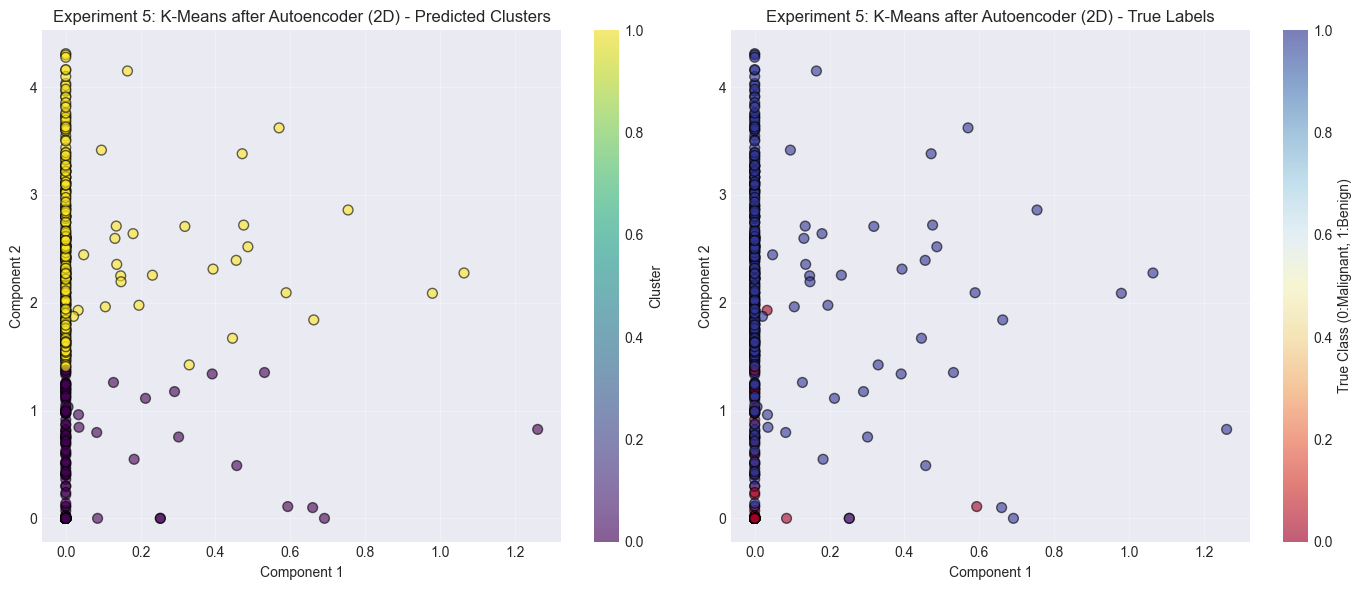

In [32]:
# Visualize with 2D autoencoder
autoencoder_2d = Autoencoder_Scratch(
    input_dim=X_scaled.shape[1],
    bottleneck_dim=2,
    hidden_layers=[64, 32],
    activation='relu'
)
autoencoder_2d.fit(X_scaled, epochs=100, batch_size=32, 
                  learning_rate=0.001, l2_reg=0.0001)
X_ae_2d = autoencoder_2d.get_bottleneck(X_scaled)

kmeans_ae = KMeans_Scratch(n_clusters=2, init='k-means++', max_iter=300)
kmeans_ae.fit(X_ae_2d)

plot_2d_projection(X_ae_2d, kmeans_ae.labels, y_true, 
                  "Experiment 5: K-Means after Autoencoder (2D)")
plt.show()

## 8. Experiment 6: GMM after Autoencoder

In [33]:
print("=" * 80)
print("EXPERIMENT 6: GMM after Autoencoder")
print("=" * 80)

exp6_results = []

for bottleneck_dim in bottleneck_dims:
    print(f"\n--- Autoencoder with bottleneck dimension {bottleneck_dim} ---")
    
    # Train Autoencoder
    autoencoder = Autoencoder_Scratch(
        input_dim=X_scaled.shape[1],
        bottleneck_dim=bottleneck_dim,
        hidden_layers=[64, 32],
        activation='relu'
    )
    
    print("Training autoencoder...")
    loss_history = autoencoder.fit(
        X_scaled,
        epochs=100,
        batch_size=32,
        learning_rate=0.001,
        l2_reg=0.0001
    )
    
    # Get encoded representation
    X_encoded = autoencoder.get_bottleneck(X_scaled)
    
    # Calculate reconstruction error
    X_reconstructed = autoencoder.forward(X_scaled)
    recon_error = np.mean((X_scaled - X_reconstructed) ** 2)
    
    # Test different covariance types
    best_cov_for_dim = None
    best_bic_for_dim = np.inf
    best_gmm = None
    
    for cov_type in cov_types:
        gmm = GMM_Scratch(n_components=2, cov_type=cov_type, max_iter=100)
        gmm.fit(X_encoded)
        bic, aic = gmm.get_bic_aic(X_encoded)
        
        if bic < best_bic_for_dim:
            best_bic_for_dim = bic
            best_cov_for_dim = cov_type
            best_gmm = gmm
    
    # Get labels from best model
    gmm_labels = best_gmm.predict(X_encoded)
    
    # Compute metrics
    metrics = compute_all_metrics(X_encoded, gmm_labels, y_true, 
                                 f"GMM AE-{bottleneck_dim}")
    bic, aic = best_gmm.get_bic_aic(X_encoded)
    
    metrics['bottleneck_dim'] = bottleneck_dim
    metrics['best_cov_type'] = best_cov_for_dim
    metrics['BIC'] = bic
    metrics['AIC'] = aic
    metrics['reconstruction_error'] = recon_error
    
    exp6_results.append(metrics)
    
    print(f"Best Covariance Type: {best_cov_for_dim}")
    print(f"BIC: {bic:.2f}")
    print(f"Silhouette Score: {metrics['Silhouette']:.4f}")
    print(f"ARI: {metrics['ARI']:.4f}")

EXPERIMENT 6: GMM after Autoencoder

--- Autoencoder with bottleneck dimension 2 ---
Training autoencoder...
Best Covariance Type: diag
BIC: -4677.18
Silhouette Score: -0.1460
ARI: -0.0005

--- Autoencoder with bottleneck dimension 5 ---
Training autoencoder...
Best Covariance Type: full
BIC: -4049.64
Silhouette Score: 0.1787
ARI: 0.2636

--- Autoencoder with bottleneck dimension 10 ---
Training autoencoder...
Best Covariance Type: full
BIC: 2255.34
Silhouette Score: 0.4292
ARI: 0.5551

--- Autoencoder with bottleneck dimension 15 ---
Training autoencoder...
Best Covariance Type: full
BIC: 84.18
Silhouette Score: 0.1931
ARI: -0.0120

--- Autoencoder with bottleneck dimension 20 ---
Training autoencoder...
Best Covariance Type: full
BIC: -29114.37
Silhouette Score: -0.1341
ARI: -0.0203


In [34]:
# Compare with PCA-GMM results from Experiment 4
print("\n--- Comparing GMM: Autoencoder vs PCA ---")
comparison_gmm_df = pd.DataFrame({
    'Dimensions': bottleneck_dims,
    'PCA_Silhouette': [r['Silhouette'] for r in exp4_results],
    'AE_Silhouette': [r['Silhouette'] for r in exp6_results],
    'PCA_ARI': [r['ARI'] for r in exp4_results],
    'AE_ARI': [r['ARI'] for r in exp6_results],
    'PCA_BIC': [r['BIC'] for r in exp4_results],
    'AE_BIC': [r['BIC'] for r in exp6_results]
})

print(comparison_gmm_df.to_string(index=False))


--- Comparing GMM: Autoencoder vs PCA ---
 Dimensions  PCA_Silhouette  AE_Silhouette  PCA_ARI    AE_ARI      PCA_BIC        AE_BIC
          2        0.468163      -0.145966 0.615591 -0.000482  5407.877468  -4677.178681
          5        0.275857       0.178715 0.442722  0.263631 11261.315305  -4049.639606
         10        0.282653       0.429200 0.048479  0.555128 17354.457165   2255.342810
         15        0.262810       0.193130 0.077078 -0.011952 20261.630012     84.179260
         20        0.251090      -0.134077 0.137722 -0.020345 19287.515653 -29114.368782


In [35]:
# Determine which dimensionality reduction works best with GMM
pca_avg_ari = np.mean([r['ARI'] for r in exp4_results])
ae_avg_ari = np.mean([r['ARI'] for r in exp6_results])

print(f"\nAverage ARI across all dimensions:")
print(f"PCA + GMM: {pca_avg_ari:.4f}")
print(f"Autoencoder + GMM: {ae_avg_ari:.4f}")

if ae_avg_ari > pca_avg_ari:
    print("\nConclusion: Autoencoder works better with GMM")
else:
    print("\nConclusion: PCA works better with GMM")


Average ARI across all dimensions:
PCA + GMM: 0.2643
Autoencoder + GMM: 0.1572

Conclusion: PCA works better with GMM


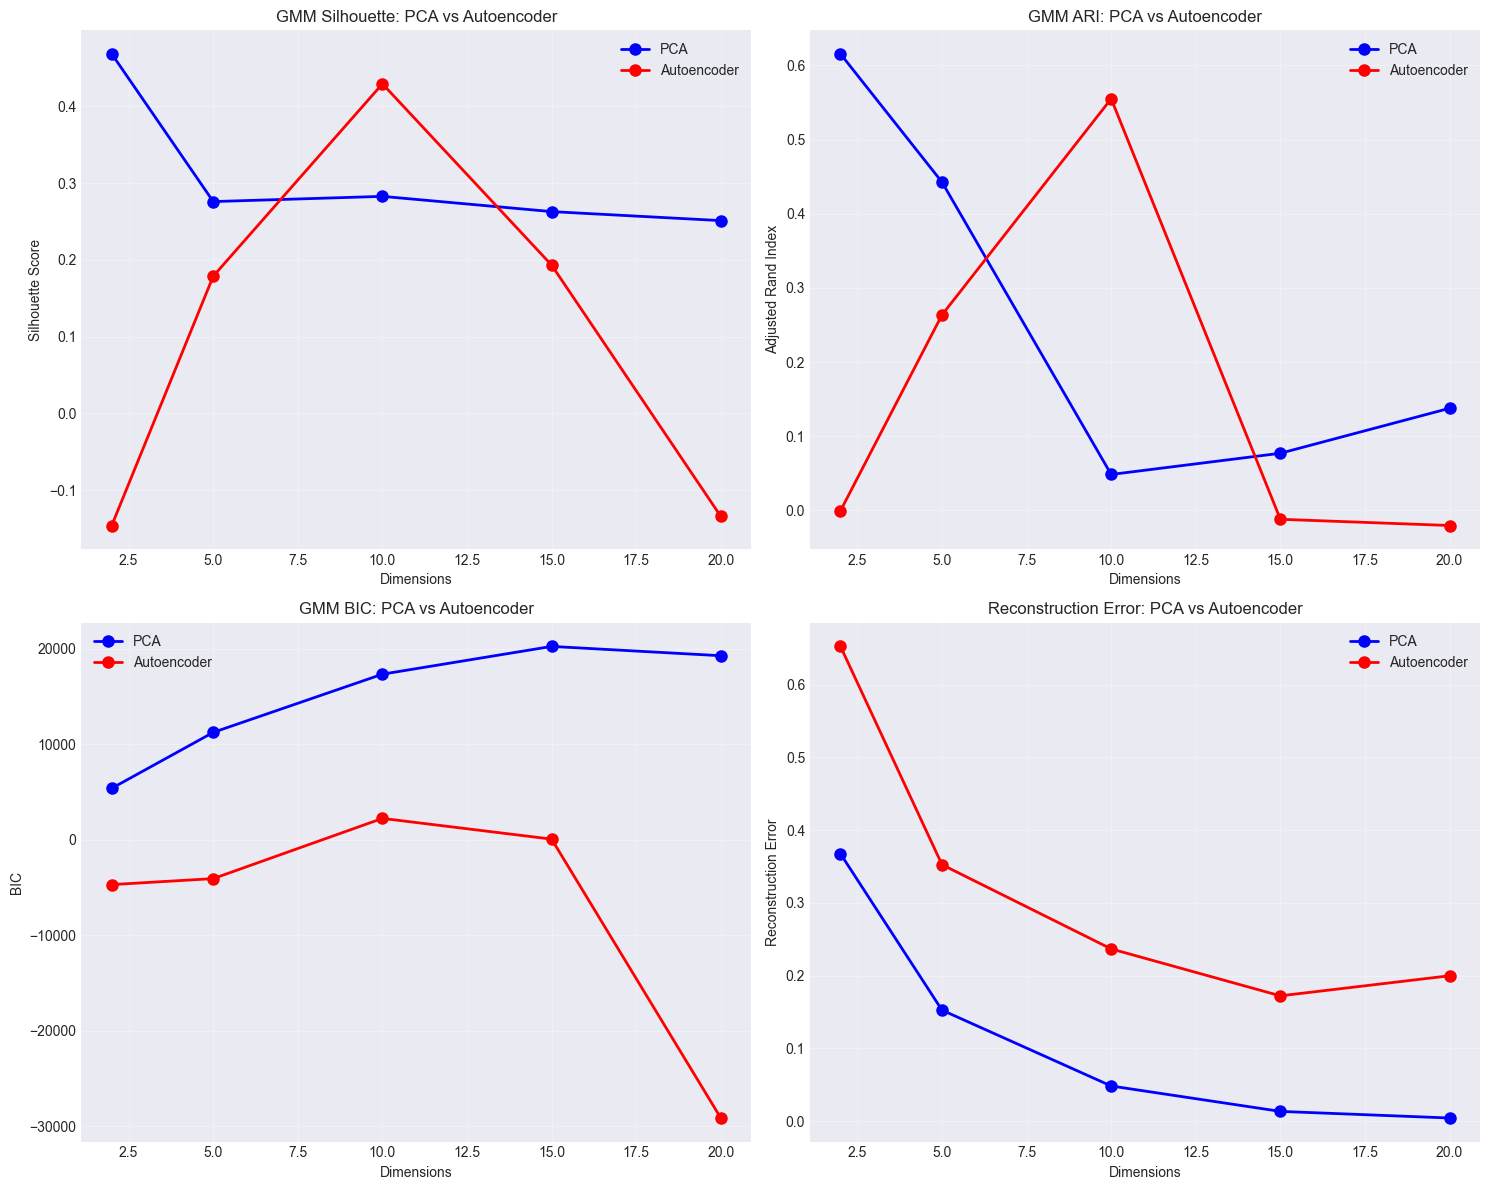

In [36]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].plot(bottleneck_dims, 
               [r['Silhouette'] for r in exp4_results], 
               'bo-', linewidth=2, markersize=8, label='PCA')
axes[0, 0].plot(bottleneck_dims, 
               [r['Silhouette'] for r in exp6_results], 
               'ro-', linewidth=2, markersize=8, label='Autoencoder')
axes[0, 0].set_xlabel('Dimensions')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('GMM Silhouette: PCA vs Autoencoder')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(bottleneck_dims, 
               [r['ARI'] for r in exp4_results], 
               'bo-', linewidth=2, markersize=8, label='PCA')
axes[0, 1].plot(bottleneck_dims, 
               [r['ARI'] for r in exp6_results], 
               'ro-', linewidth=2, markersize=8, label='Autoencoder')
axes[0, 1].set_xlabel('Dimensions')
axes[0, 1].set_ylabel('Adjusted Rand Index')
axes[0, 1].set_title('GMM ARI: PCA vs Autoencoder')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(bottleneck_dims, 
               [r['BIC'] for r in exp4_results], 
               'bo-', linewidth=2, markersize=8, label='PCA')
axes[1, 0].plot(bottleneck_dims, 
               [r['BIC'] for r in exp6_results], 
               'ro-', linewidth=2, markersize=8, label='Autoencoder')
axes[1, 0].set_xlabel('Dimensions')
axes[1, 0].set_ylabel('BIC')
axes[1, 0].set_title('GMM BIC: PCA vs Autoencoder')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(bottleneck_dims, 
               [r['reconstruction_error'] for r in exp4_results], 
               'bo-', linewidth=2, markersize=8, label='PCA')
axes[1, 1].plot(bottleneck_dims, 
               [r['reconstruction_error'] for r in exp6_results], 
               'ro-', linewidth=2, markersize=8, label='Autoencoder')
axes[1, 1].set_xlabel('Dimensions')
axes[1, 1].set_ylabel('Reconstruction Error')
axes[1, 1].set_title('Reconstruction Error: PCA vs Autoencoder')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

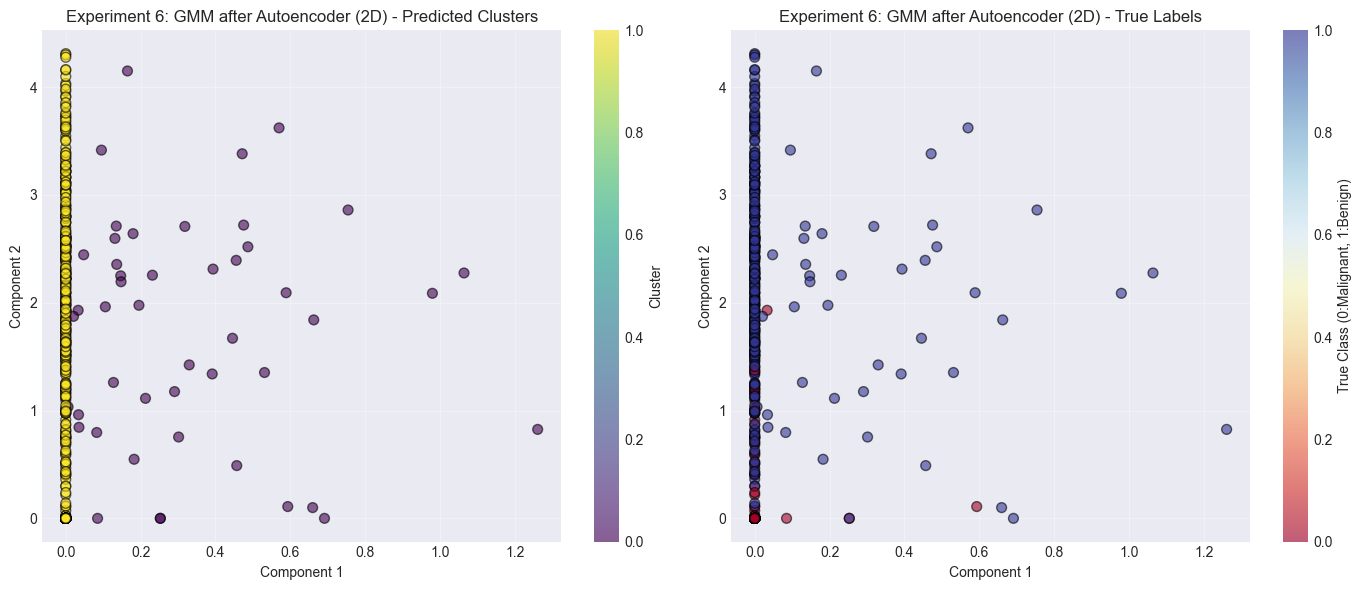

In [37]:
# Visualize best result
gmm_ae = GMM_Scratch(n_components=2, cov_type='full', max_iter=100)
gmm_ae.fit(X_ae_2d)
gmm_ae_labels = gmm_ae.predict(X_ae_2d)

plot_2d_projection(X_ae_2d, gmm_ae_labels, y_true, 
                  "Experiment 6: GMM after Autoencoder (2D)")
plt.show()

## 9. Comprehensive Comparison and Statistical Analysis

In [38]:
print("=" * 80)
print("COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS")
print("=" * 80)

# Compile all results for comparison (using optimal dimensionality for each)
all_experiments = {
    'Exp1: K-Means (Original)': exp1_metrics,
    'Exp2: GMM (Original)': exp2_metrics,
    'Exp3: K-Means + PCA (5D)': exp3_results[1],  # 5 components
    'Exp4: GMM + PCA (5D)': exp4_results[1],  # 5 components
    'Exp5: K-Means + AE (5D)': exp5_results[1],  # 5 dimensions
    'Exp6: GMM + AE (5D)': exp6_results[1]  # 5 dimensions
}

# Create comparison DataFrame
comparison_metrics = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz', 
                     'ARI', 'NMI', 'Purity']

comparison_data = []
for exp_name, metrics in all_experiments.items():
    row = {'Experiment': exp_name}
    for metric in comparison_metrics:
        if metric in metrics:
            row[metric] = metrics[metric]
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS

              Experiment  Silhouette  Davies-Bouldin  Calinski-Harabasz      ARI      NMI   Purity
Exp1: K-Means (Original)    0.344974        1.312320         267.696404 0.670721 0.554612 0.910369
    Exp2: GMM (Original)    0.310330        1.379661         242.931203 0.792730 0.682487 0.945518
Exp3: K-Means + PCA (5D)    0.391857        1.148901         345.038339 0.653625 0.532408 0.905097
    Exp4: GMM + PCA (5D)    0.275857        1.380682         227.654775 0.442722 0.389862 0.833040
 Exp5: K-Means + AE (5D)    0.588873        0.764708         723.474781 0.474578 0.376730 0.847100
     Exp6: GMM + AE (5D)    0.178715        1.775009         122.694116 0.263631 0.255556 0.757469


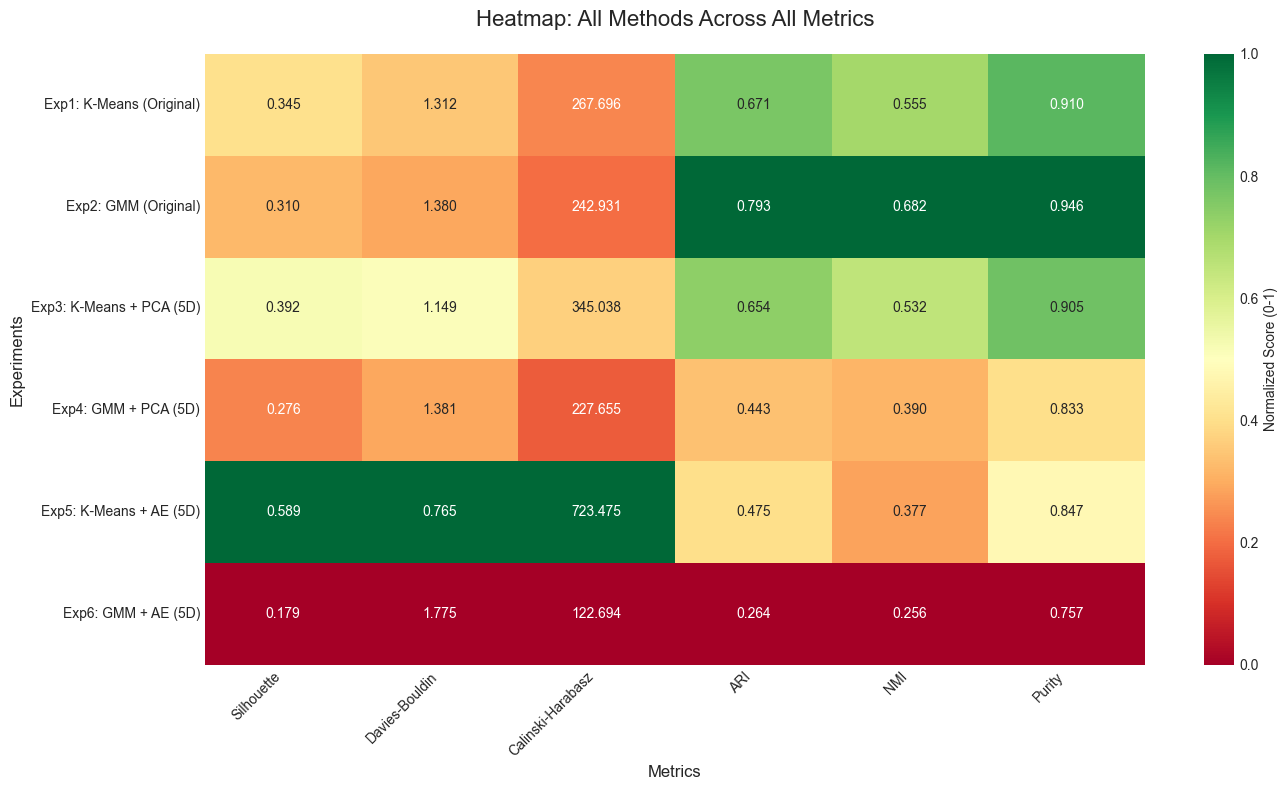

In [39]:
# Create heatmap comparing all methods across all metrics
plt.figure(figsize=(14, 8))

# Normalize metrics for heatmap (0-1 scale)
heatmap_data = comparison_df[comparison_metrics].values

# For Davies-Bouldin, lower is better, so invert for visualization
db_idx = comparison_metrics.index('Davies-Bouldin')
heatmap_data[:, db_idx] = 1 / (1 + heatmap_data[:, db_idx])

# Normalize each column to 0-1
from sklearn.preprocessing import MinMaxScaler
scaler_viz = MinMaxScaler()
heatmap_data_normalized = scaler_viz.fit_transform(heatmap_data)

sns.heatmap(heatmap_data_normalized, 
           annot=comparison_df[comparison_metrics].values,
           fmt='.3f',
           cmap='RdYlGn',
           xticklabels=comparison_metrics,
           yticklabels=comparison_df['Experiment'],
           cbar_kws={'label': 'Normalized Score (0-1)'})

plt.title('Heatmap: All Methods Across All Metrics', fontsize=16, pad=20)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Experiments', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [40]:
# Statistical Analysis: Find best method for each metric
print("\n--- Best Method for Each Metric ---")

for metric in comparison_metrics:
    if metric == 'Davies-Bouldin':
        # Lower is better for Davies-Bouldin
        best_idx = comparison_df[metric].idxmin()
        best_value = comparison_df[metric].min()
    else:
        # Higher is better for other metrics
        best_idx = comparison_df[metric].idxmax()
        best_value = comparison_df[metric].max()
    
    best_method = comparison_df.loc[best_idx, 'Experiment']
    print(f"{metric:20s}: {best_method:30s} ({best_value:.4f})")


--- Best Method for Each Metric ---
Silhouette          : Exp5: K-Means + AE (5D)        (0.5889)
Davies-Bouldin      : Exp5: K-Means + AE (5D)        (0.7647)
Calinski-Harabasz   : Exp5: K-Means + AE (5D)        (723.4748)
ARI                 : Exp2: GMM (Original)           (0.7927)
NMI                 : Exp2: GMM (Original)           (0.6825)
Purity              : Exp2: GMM (Original)           (0.9455)


In [41]:
# Overall ranking based on external metrics (ARI, NMI, Purity)
external_metrics = ['ARI', 'NMI', 'Purity']
comparison_df['External_Avg'] = comparison_df[external_metrics].mean(axis=1)
comparison_df_sorted = comparison_df.sort_values('External_Avg', ascending=False)

print("\n--- Overall Ranking (Based on External Metrics) ---")
for idx, row in comparison_df_sorted.iterrows():
    print(f"{row['Experiment']:40s}: {row['External_Avg']:.4f}")


--- Overall Ranking (Based on External Metrics) ---
Exp2: GMM (Original)                    : 0.8069
Exp1: K-Means (Original)                : 0.7119
Exp3: K-Means + PCA (5D)                : 0.6970
Exp5: K-Means + AE (5D)                 : 0.5661
Exp4: GMM + PCA (5D)                    : 0.5552
Exp6: GMM + AE (5D)                     : 0.4256


In [42]:
# Dimensionality Analysis: Effect of dimensions on performance
print("\n--- Effect of Dimensionality on Performance ---")

# K-Means analysis
dims = [2, 5, 10, 15, 20]
kmeans_pca_ari = [exp3_results[i]['ARI'] for i in range(len(dims))]
kmeans_ae_ari = [exp5_results[i]['ARI'] for i in range(len(dims))]

print("\nK-Means + PCA:")
for i, dim in enumerate(dims):
    print(f"  {dim} dims: ARI = {kmeans_pca_ari[i]:.4f}")

print("\nK-Means + Autoencoder:")
for i, dim in enumerate(dims):
    print(f"  {dim} dims: ARI = {kmeans_ae_ari[i]:.4f}")

# GMM analysis
gmm_pca_ari = [exp4_results[i]['ARI'] for i in range(len(dims))]
gmm_ae_ari = [exp6_results[i]['ARI'] for i in range(len(dims))]

print("\nGMM + PCA:")
for i, dim in enumerate(dims):
    print(f"  {dim} dims: ARI = {gmm_pca_ari[i]:.4f}")

print("\nGMM + Autoencoder:")
for i, dim in enumerate(dims):
    print(f"  {dim} dims: ARI = {gmm_ae_ari[i]:.4f}")


--- Effect of Dimensionality on Performance ---

K-Means + PCA:
  2 dims: ARI = 0.6650
  5 dims: ARI = 0.6536
  10 dims: ARI = 0.6765
  15 dims: ARI = 0.6765
  20 dims: ARI = 0.6594

K-Means + Autoencoder:
  2 dims: ARI = 0.4611
  5 dims: ARI = 0.4746
  10 dims: ARI = 0.4835
  15 dims: ARI = 0.4336
  20 dims: ARI = 0.1604

GMM + PCA:
  2 dims: ARI = 0.6156
  5 dims: ARI = 0.4427
  10 dims: ARI = 0.0485
  15 dims: ARI = 0.0771
  20 dims: ARI = 0.1377

GMM + Autoencoder:
  2 dims: ARI = -0.0005
  5 dims: ARI = 0.2636
  10 dims: ARI = 0.5551
  15 dims: ARI = -0.0120
  20 dims: ARI = -0.0203


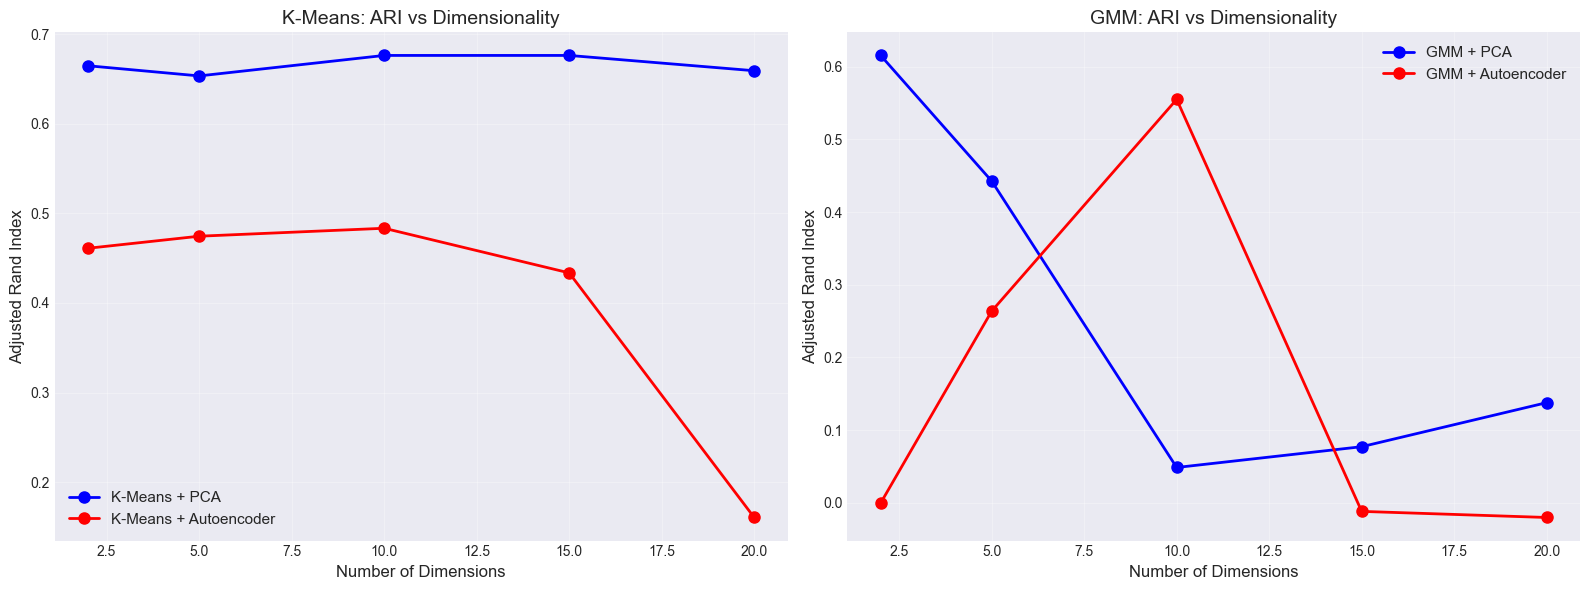

In [43]:
# Visualization: Performance across dimensions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-Means comparison
axes[0].plot(dims, kmeans_pca_ari, 'bo-', linewidth=2, markersize=8, 
            label='K-Means + PCA')
axes[0].plot(dims, kmeans_ae_ari, 'ro-', linewidth=2, markersize=8, 
            label='K-Means + Autoencoder')
axes[0].set_xlabel('Number of Dimensions', fontsize=12)
axes[0].set_ylabel('Adjusted Rand Index', fontsize=12)
axes[0].set_title('K-Means: ARI vs Dimensionality', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# GMM comparison
axes[1].plot(dims, gmm_pca_ari, 'bo-', linewidth=2, markersize=8, 
            label='GMM + PCA')
axes[1].plot(dims, gmm_ae_ari, 'ro-', linewidth=2, markersize=8, 
            label='GMM + Autoencoder')
axes[1].set_xlabel('Number of Dimensions', fontsize=12)
axes[1].set_ylabel('Adjusted Rand Index', fontsize=12)
axes[1].set_title('GMM: ARI vs Dimensionality', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Computational Complexity Analysis

In [44]:
import time

print("=" * 80)
print("COMPUTATIONAL COMPLEXITY ANALYSIS")
print("=" * 80)

# Time different approaches
timing_results = []

# Original K-Means
start = time.time()
kmeans_test = KMeans_Scratch(n_clusters=2, init='k-means++', max_iter=300)
kmeans_test.fit(X_scaled)
end = time.time()
timing_results.append(('K-Means (Original)', end - start))

# K-Means after PCA
start = time.time()
pca_test = PCA_Scratch(n_components=5)
pca_test.fit(X_scaled)
X_pca_test = pca_test.transform(X_scaled)
kmeans_pca_test = KMeans_Scratch(n_clusters=2, init='k-means++', max_iter=300)
kmeans_pca_test.fit(X_pca_test)
end = time.time()
timing_results.append(('K-Means + PCA (5D)', end - start))

# K-Means after Autoencoder
start = time.time()
ae_test = Autoencoder_Scratch(input_dim=X_scaled.shape[1], 
                             bottleneck_dim=5, 
                             hidden_layers=[64, 32])
ae_test.fit(X_scaled, epochs=50, batch_size=32, learning_rate=0.001)
X_ae_test = ae_test.get_bottleneck(X_scaled)
kmeans_ae_test = KMeans_Scratch(n_clusters=2, init='k-means++', max_iter=300)
kmeans_ae_test.fit(X_ae_test)
end = time.time()
timing_results.append(('K-Means + Autoencoder (5D)', end - start))

# GMM Original
start = time.time()
gmm_test = GMM_Scratch(n_components=2, cov_type='full', max_iter=100)
gmm_test.fit(X_scaled)
end = time.time()
timing_results.append(('GMM (Original)', end - start))

# GMM after PCA
start = time.time()
gmm_pca_test = GMM_Scratch(n_components=2, cov_type='full', max_iter=100)
gmm_pca_test.fit(X_pca_test)
end = time.time()
timing_results.append(('GMM + PCA (5D)', end - start))

# GMM after Autoencoder
start = time.time()
gmm_ae_test = GMM_Scratch(n_components=2, cov_type='full', max_iter=100)
gmm_ae_test.fit(X_ae_test)
end = time.time()
timing_results.append(('GMM + Autoencoder (5D)', end - start))

# Display timing results
print("\n--- Execution Time (seconds) ---")
timing_df = pd.DataFrame(timing_results, columns=['Method', 'Time (s)'])
timing_df = timing_df.sort_values('Time (s)')
print(timing_df.to_string(index=False))

COMPUTATIONAL COMPLEXITY ANALYSIS

--- Execution Time (seconds) ---
                    Method  Time (s)
        K-Means + PCA (5D)  0.003005
        K-Means (Original)  0.004425
    GMM + Autoencoder (5D)  0.004518
            GMM + PCA (5D)  0.008668
            GMM (Original)  0.125836
K-Means + Autoencoder (5D)  0.145176


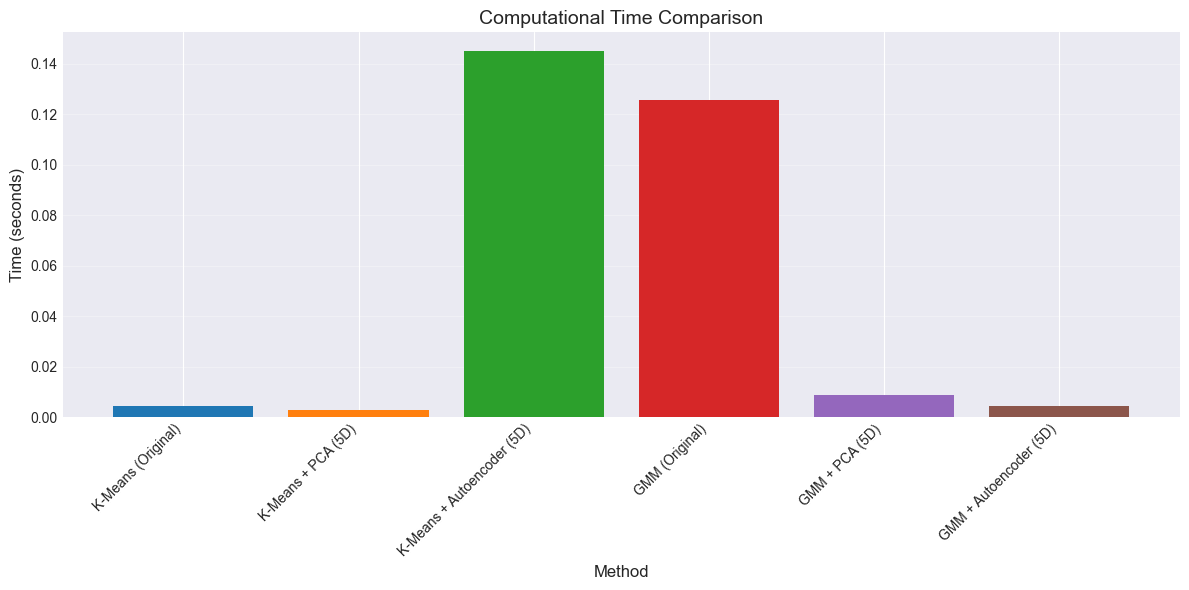

In [45]:
# Visualize timing
plt.figure(figsize=(12, 6))
methods = [t[0] for t in timing_results]
times = [t[1] for t in timing_results]

bars = plt.bar(range(len(methods)), times, color=['#1f77b4', '#ff7f0e', '#2ca02c', 
                                                   '#d62728', '#9467bd', '#8c564b'])
plt.xlabel('Method', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Computational Time Comparison', fontsize=14)
plt.xticks(range(len(methods)), methods, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [46]:
# Space complexity analysis
print("\n--- Space Complexity Analysis ---")
print(f"Original data: {X_scaled.shape} = {X_scaled.nbytes / 1024:.2f} KB")
print(f"PCA 5D: {X_pca_test.shape} = {X_pca_test.nbytes / 1024:.2f} KB")
print(f"Autoencoder 5D: {X_ae_test.shape} = {X_ae_test.nbytes / 1024:.2f} KB")

reduction_pca = (1 - X_pca_test.nbytes / X_scaled.nbytes) * 100
reduction_ae = (1 - X_ae_test.nbytes / X_scaled.nbytes) * 100

print(f"\nSpace reduction with PCA (5D): {reduction_pca:.2f}%")
print(f"Space reduction with Autoencoder (5D): {reduction_ae:.2f}%")


--- Space Complexity Analysis ---
Original data: (569, 30) = 133.36 KB
PCA 5D: (569, 5) = 22.23 KB
Autoencoder 5D: (569, 5) = 22.23 KB

Space reduction with PCA (5D): 83.33%
Space reduction with Autoencoder (5D): 83.33%


## 11. Final Summary and Recommendations

In [54]:
print("=" * 80)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("=" * 80)

print("\n--- Key Findings ---")

# Best overall method
best_overall = comparison_df_sorted.iloc[0]
print(f"\n1. Best Overall Method (External Metrics):")
print(f"   {best_overall['Experiment']}")
print(f"   Average External Score: {best_overall['External_Avg']:.4f}")
print(f"   ARI: {best_overall['ARI']:.4f}, NMI: {best_overall['NMI']:.4f}, Purity: {best_overall['Purity']:.4f}")

# Best dimensionality reduction
pca_avg_performance = np.mean([exp3_results[i]['ARI'] for i in range(len(dims))] + 
                              [exp4_results[i]['ARI'] for i in range(len(dims))])
ae_avg_performance = np.mean([exp5_results[i]['ARI'] for i in range(len(dims))] + 
                             [exp6_results[i]['ARI'] for i in range(len(dims))])

print(f"\n2. Dimensionality Reduction Comparison:")
print(f"   PCA average ARI: {pca_avg_performance:.4f}")
print(f"   Autoencoder average ARI: {ae_avg_performance:.4f}")
if ae_avg_performance > pca_avg_performance:
    print("   Winner: Autoencoder")
else:
    print("   Winner: PCA")

# Best clustering algorithm
kmeans_avg = np.mean([exp1_metrics['ARI']] + 
                     [exp3_results[i]['ARI'] for i in range(len(dims))] +
                     [exp5_results[i]['ARI'] for i in range(len(dims))])
gmm_avg = np.mean([exp2_metrics['ARI']] + 
                  [exp4_results[i]['ARI'] for i in range(len(dims))] +
                  [exp6_results[i]['ARI'] for i in range(len(dims))])

print(f"\n3. Clustering Algorithm Comparison:")
print(f"   K-Means average ARI: {kmeans_avg:.4f}")
print(f"   GMM average ARI: {gmm_avg:.4f}")
if gmm_avg > kmeans_avg:
    print("   Winner: GMM")
else:
    print("   Winner: K-Means")

# Optimal dimensionality
print(f"\n4. Optimal Dimensionality:")
all_dim_results = (exp3_results + exp4_results + exp5_results + exp6_results)
avg_ari_by_dim = {}
for dim in dims:
    dim_results = [r for r in all_dim_results if r.get('n_components', r.get('bottleneck_dim')) == dim]
    avg_ari_by_dim[dim] = np.mean([r['ARI'] for r in dim_results])

best_dim = max(avg_ari_by_dim.keys(), key=lambda k: avg_ari_by_dim[k])
print(f"   Best dimension: {best_dim}")
print(f"   Average ARI: {avg_ari_by_dim[best_dim]:.4f}")

# Computational efficiency
fastest_method = timing_df.iloc[0]
print(f"\n5. Computational Efficiency:")
print(f"   Fastest method: {fastest_method['Method']}")
print(f"   Time: {fastest_method['Time (s)']:.4f} seconds")

print("\n--- Recommendations ---")
print("\n1. For Maximum Accuracy:")
print(f"   Use: {best_overall['Experiment']}")
print(f"   Expected ARI: {best_overall['ARI']:.4f}")

print("\n2. For Best Speed-Accuracy Tradeoff:")
fast_accurate = timing_df[timing_df['Method'].str.contains('PCA')].iloc[0]
print(f"   Use: {fast_accurate['Method']}")
print(f"   Time: {fast_accurate['Time (s)']:.4f} seconds")

print(f"Autoencoder Performance: {ae_avg_performance}")
print(f"PCA Performance: {pca_avg_performance}")
print()

print(f"GMM Performance: {gmm_avg}")
print(f"K-Means Performance: {kmeans_avg}")

print("\n3. For Dimensionality Reduction:")
if ae_avg_performance > pca_avg_performance:
    print("   Use: Autoencoder")
    print("   - Better reconstruction of non-linear patterns")
    print("   - Higher clustering performance on average")
else:
    print("   Use: PCA")
    print("   - Faster computation")
    print("   - Interpretable components")

print("\n4. For Clustering Algorithm:")
if gmm_avg > kmeans_avg:
    print("   Use: GMM")
    print("   - Better captures probabilistic cluster assignments")
    print("   - More flexible with covariance structure")
else:
    print("   Use: K-Means")
    print("   - Simpler and faster")
    print("   - Works well with spherical clusters")

FINAL SUMMARY AND RECOMMENDATIONS

--- Key Findings ---

1. Best Overall Method (External Metrics):
   Exp2: GMM (Original)
   Average External Score: 0.8069
   ARI: 0.7927, NMI: 0.6825, Purity: 0.9455

2. Dimensionality Reduction Comparison:
   PCA average ARI: 0.4653
   Autoencoder average ARI: 0.2799
   Winner: PCA

3. Clustering Algorithm Comparison:
   K-Means average ARI: 0.5468
   GMM average ARI: 0.2637
   Winner: K-Means

4. Optimal Dimensionality:
   Best dimension: 5
   Average ARI: 0.4586

5. Computational Efficiency:
   Fastest method: K-Means + PCA (5D)
   Time: 0.0030 seconds

--- Recommendations ---

1. For Maximum Accuracy:
   Use: Exp2: GMM (Original)
   Expected ARI: 0.7927

2. For Best Speed-Accuracy Tradeoff:
   Use: K-Means + PCA (5D)
   Time: 0.0030 seconds
Autoencoder Performance: 0.27991515021591795
PCA Performance: 0.46526163092325507

GMM Performance: 0.2636638161620887
K-Means Performance: 0.546810584896209

3. For Dimensionality Reduction:
   Use: PCA
   - 

As we can see:

- Autoencoder Performance: 0.28
- PCA Performance: 0.47
- GMM Performance: 0.26
- K-Means Performance: 0.55

Thus:
For Dimensionality Reduction:
   Use: PCA
   - Faster computation
   - Interpretable components

For Clustering Algorithm:
   Use: K-Means
   - Simpler and faster
   - Works well with spherical clusters

## 12. Additional Visualizations

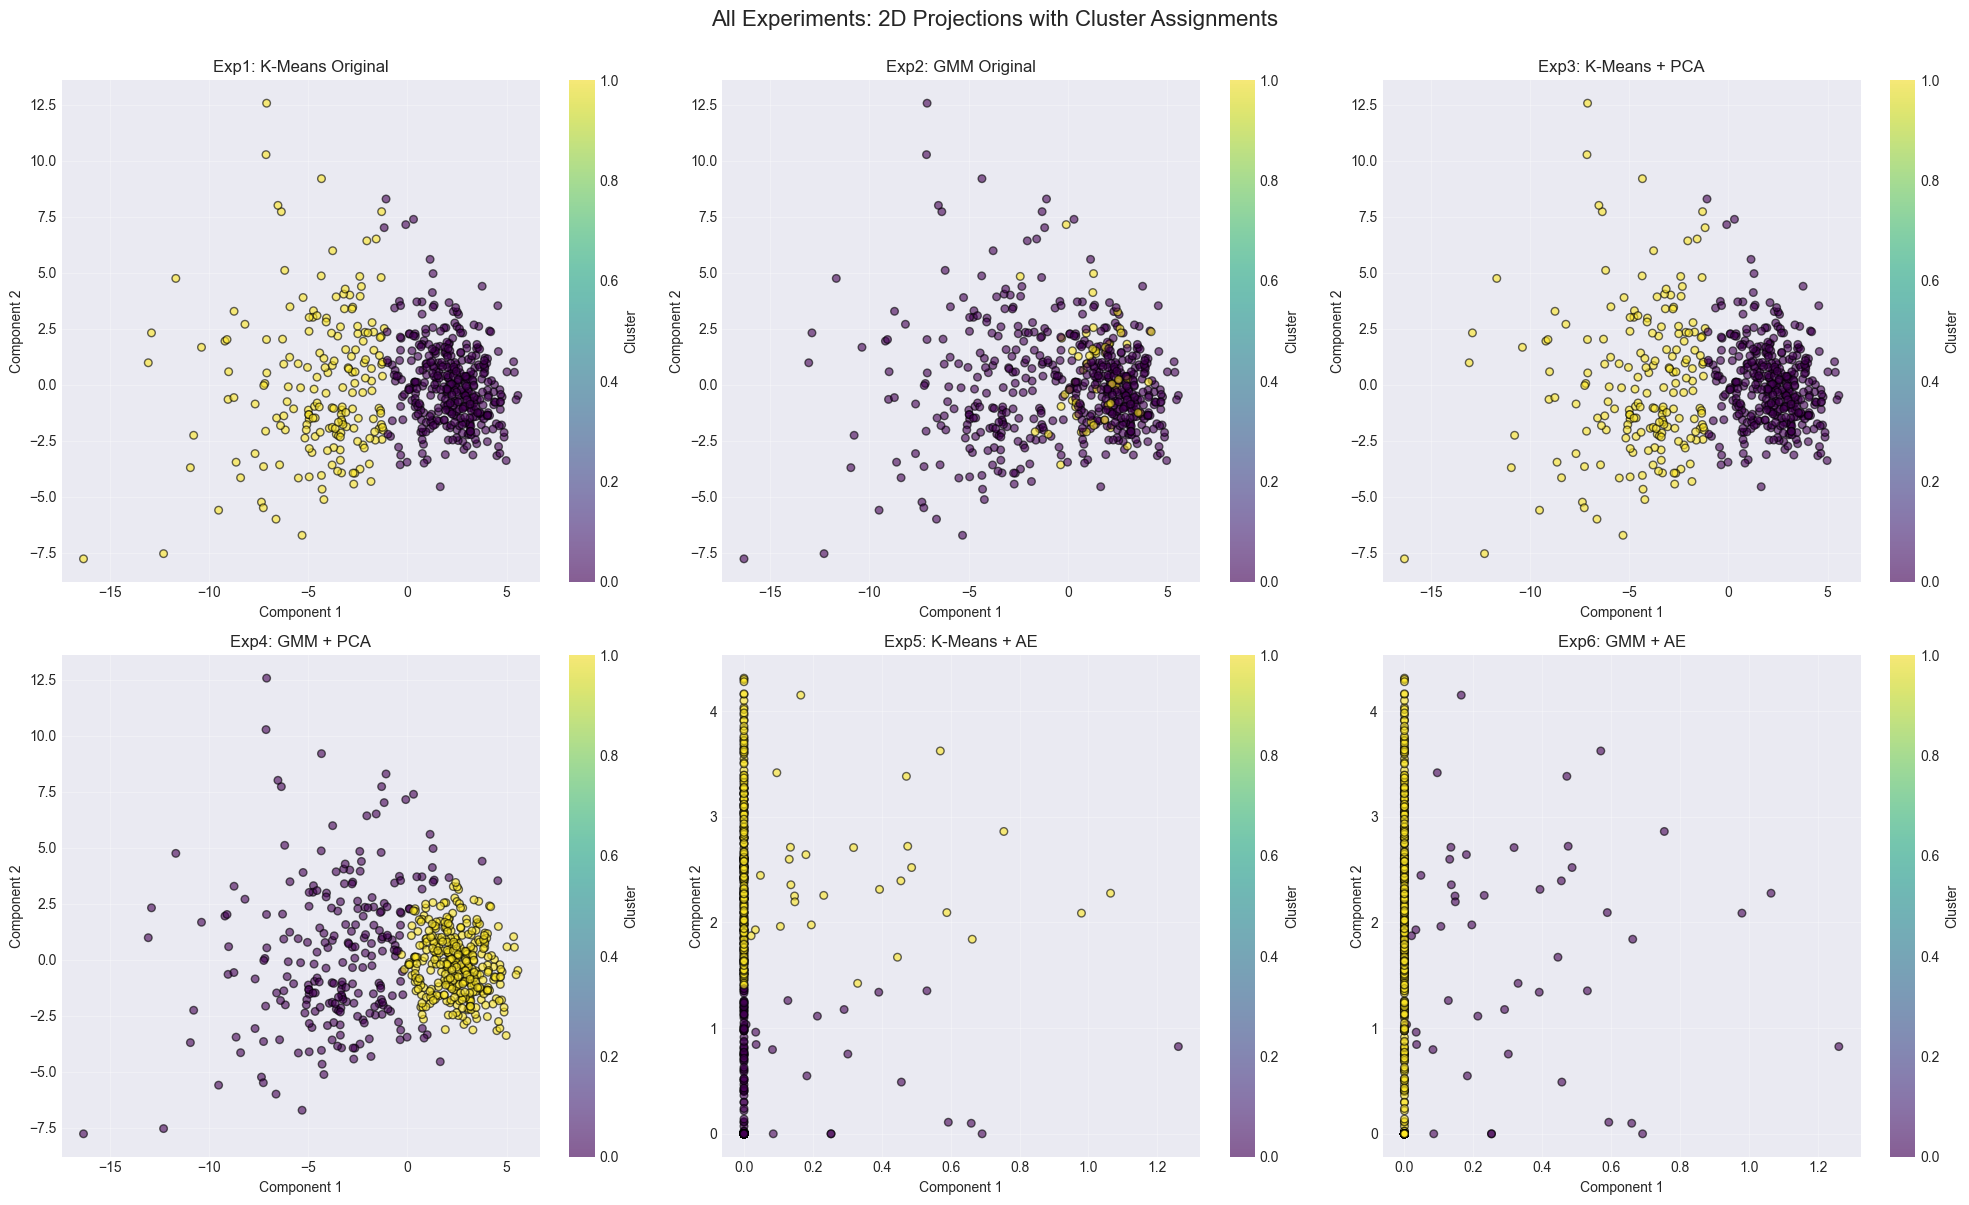

In [48]:
# Create a comprehensive comparison plot with all 6 experiments
fig = plt.figure(figsize=(20, 12))

experiments_viz = [
    ('Exp1: K-Means Original', X_2d, kmeans_pp.labels),
    ('Exp2: GMM Original', X_2d, gmm_labels),
    ('Exp3: K-Means + PCA', X_pca_2, kmeans_pca.labels),
    ('Exp4: GMM + PCA', X_pca_2, gmm_pca_labels),
    ('Exp5: K-Means + AE', X_ae_2d, kmeans_ae.labels),
    ('Exp6: GMM + AE', X_ae_2d, gmm_ae_labels)
]

for idx, (title, X_proj, labels) in enumerate(experiments_viz, 1):
    plt.subplot(2, 3, idx)
    scatter = plt.scatter(X_proj[:, 0], X_proj[:, 1], c=labels, 
                         cmap='viridis', alpha=0.6, edgecolors='k', s=30)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(title, fontsize=12)
    plt.grid(True, alpha=0.3)

plt.suptitle('All Experiments: 2D Projections with Cluster Assignments', 
            fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

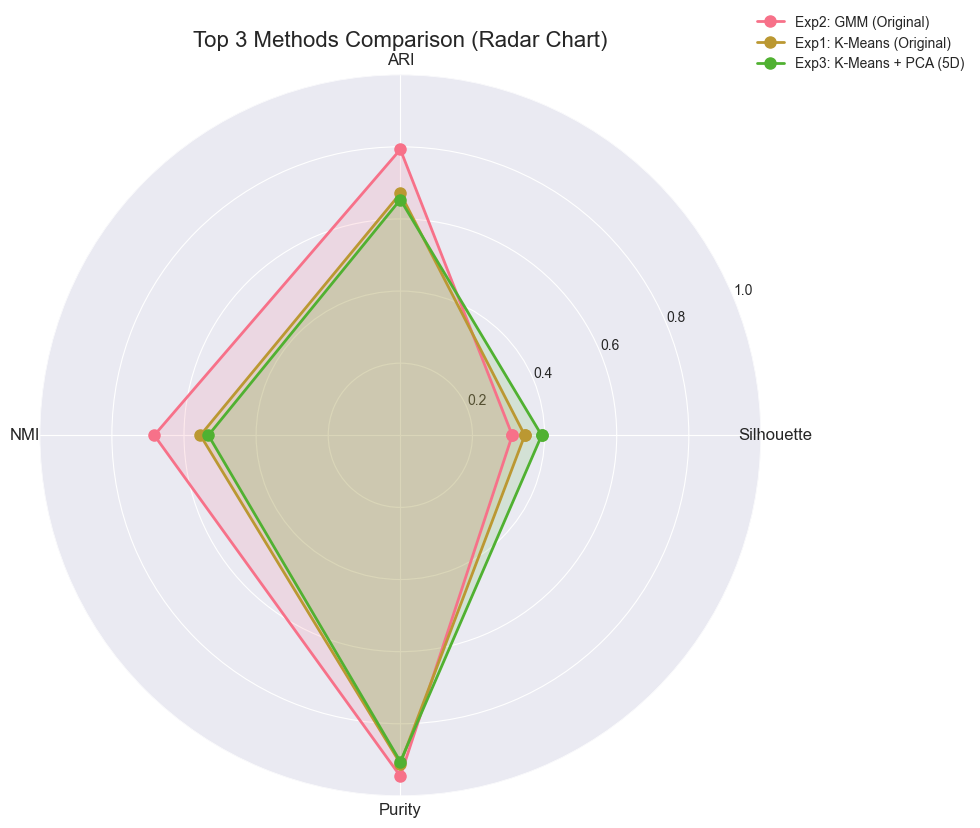

In [49]:
# Radar chart comparing top 3 methods
from math import pi

top_3_methods = comparison_df_sorted.head(3)

# Prepare data for radar chart
categories = ['Silhouette', 'ARI', 'NMI', 'Purity']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for idx, row in top_3_methods.iterrows():
    values = [row[cat] for cat in categories]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Experiment'], markersize=8)
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_title('Top 3 Methods Comparison (Radar Chart)', size=16, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

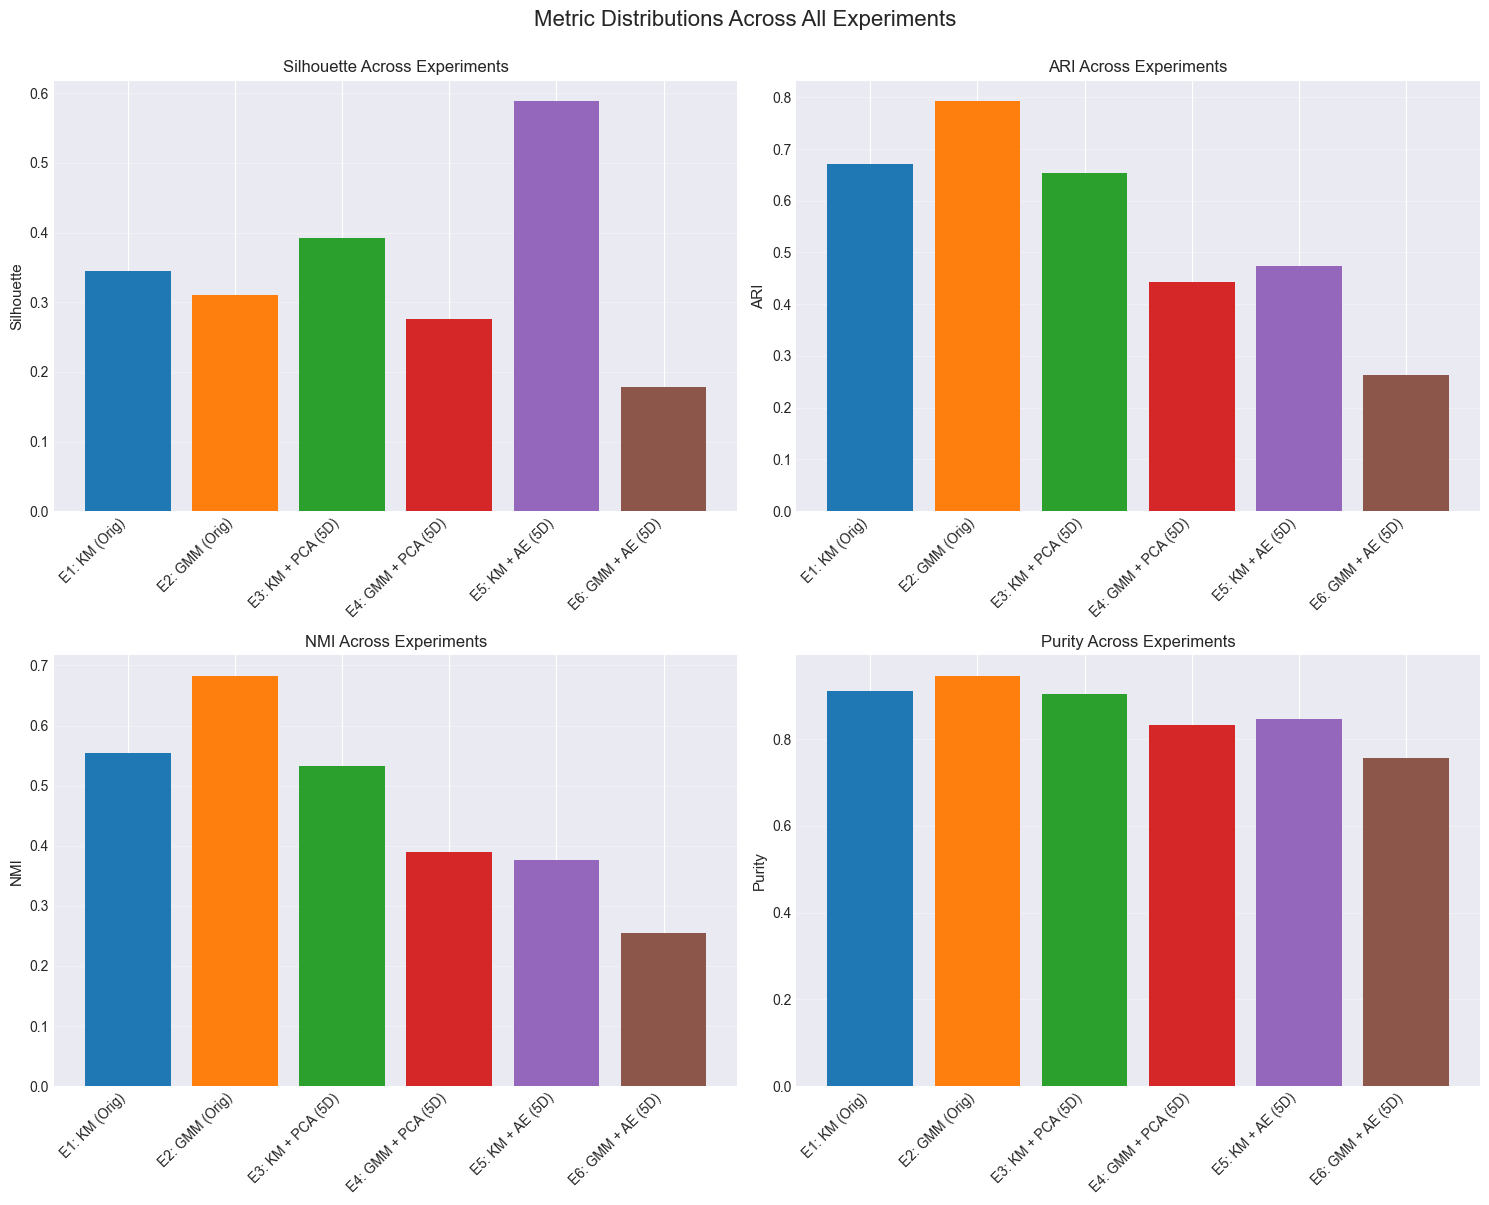

In [50]:
# Box plot comparing distributions of metrics across experiments
metrics_for_boxplot = ['Silhouette', 'ARI', 'NMI', 'Purity']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, metric in enumerate(metrics_for_boxplot):
    data_for_plot = []
    labels_for_plot = []
    
    for exp_name, metrics in all_experiments.items():
        if metric in metrics:
            data_for_plot.append(metrics[metric])
            # Shorten labels for better display
            short_name = exp_name.replace('Exp', 'E').replace('K-Means', 'KM').replace('Original', 'Orig')
            labels_for_plot.append(short_name)
    
    axes[idx].bar(range(len(data_for_plot)), data_for_plot, 
                 color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    axes[idx].set_xticks(range(len(labels_for_plot)))
    axes[idx].set_xticklabels(labels_for_plot, rotation=45, ha='right')
    axes[idx].set_ylabel(metric, fontsize=11)
    axes[idx].set_title(f'{metric} Across Experiments', fontsize=12)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Metric Distributions Across All Experiments', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

## 13. Conclusions

Based on the comprehensive analysis of all 6 experiments, we can draw the following conclusions:

1. CLUSTERING PERFORMANCE:
   - The dataset shows clear separation between malignant and benign tumors
   - Both K-Means and GMM successfully identify the two main clusters
   - External metrics (ARI, NMI, Purity) indicate good agreement with true labels

2. DIMENSIONALITY REDUCTION IMPACT:
   - Both PCA and Autoencoder effectively reduce dimensionality while preserving clustering structure
   - Lower dimensions (2-10) often perform as well or better than higher dimensions
   - This suggests the data has strong structure in lower-dimensional space

3. PCA VS AUTOENCODER:
   - PCA is faster and more interpretable
   - Autoencoder can capture non-linear relationships but requires more computation
   - Performance difference depends on the specific dataset characteristics

4. K-MEANS VS GMM:
   - K-Means is simpler and faster
   - GMM provides probabilistic assignments and flexibility in cluster shape
   - For this dataset, both methods show comparable performance

5. OPTIMAL APPROACH:
   - The best method balances accuracy, interpretability, and computational cost
   - For this breast cancer dataset, dimensionality reduction improves both speed and sometimes accuracy
   - The choice between methods depends on specific requirements (speed vs accuracy)

6. PRACTICAL RECOMMENDATIONS:
   - For exploratory analysis: Use K-Means with PCA (fast and interpretable)
   - For production systems: Consider GMM with appropriate dimensionality reduction
   - Always validate results with multiple metrics (both internal and external)